In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import blitzgsea as blitz
#from gprofiler import gprofiler
#from gprofiler import Gprofiler
import matplotlib.cm
import matplotlib.colors

In [5]:
adata = pt.dt.mcfarland_2020()
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

View of AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We want to query the GDSC scores for the cell line-perturbation combinations in our dataset. We tested annotating either via SangerID, COSMICID, or cell line name. We found that most cell lines are identified when using the SangerID.

In [7]:
cl_metadata = pt.md.CellLine()

cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["SangerModelID"],
)

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_1",
)
adata.obs["auc_gdsc1"] = adata.obs["auc_gdsc"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_2",
)
adata.obs["auc_gdsc2"] = adata.obs["auc_gdsc"].copy()

del adata.obs["auc_gdsc"]

cl_metadata.annotate_from_prism(
    adata,
    query_id="DepMap_ID",
    query_perturbation='perturbation',
)

adata

• There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation, leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
• There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation, leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


Output()

• There are 172 identifiers in `adata.obs`.However, 9 identifiers can't be found in the drug response annotation, leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'SangerModelID', 'perturbation', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'ln_ic50_gdsc', 'auc_gdsc1', 'auc_gdsc2', 'ic50_prism', 'ec50_prism', 'auc_prism'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [8]:
adata.obs

DepMap_ID SangerModelID perturbation  cancer  \
index                                                               
AAACCTGAGACAAGCC    ACH-000174     SIDM00931   Navitoclax    True   
AAACCTGAGAGATGAG    ACH-000601     SIDM00505   Navitoclax    True   
AAACCTGAGCGTTGCC    ACH-000601     SIDM00505   Navitoclax    True   
AAACCTGAGTAGGCCA    ACH-000950     SIDM00839   Navitoclax    True   
AAACCTGAGTTCGATC    ACH-000704     SIDM00480   Navitoclax    True   
...                        ...           ...          ...     ...   
TTTGGTTCAGCCTGTG    ACH-001190     SIDM00082      control    True   
TTTGTCAAGTGGGCTA-1  ACH-000189     SIDM00235      control    True   
TTTGTCACACTAAGTC-1  ACH-000397           NaN      control    True   
TTTGTCACAGCTCGAC-1  ACH-000875     SIDM00726      control    True   
TTTGTCAGTCTTGATG-1  ACH-000397           NaN      control    True   

                    cell_det_rate cell_line cell_quality channel  \
index                                                              
AAACCTGAGACAAGCC         0.114940     CAL62       normal     nan   
AAACCTGAGAGATGAG         0.122660  MIAPACA2       normal     nan   
AAACCTGAGCGTTGCC         0.176608  MIAPACA2       normal     nan   
AAACCTGAGTAGGCCA         0.177802      LOVO       normal     nan   
AAACCTGAGTTCGATC         0.158993     OAW42       normal     nan   
...                           ...       ...          ...     ...   
TTTGGTTCAGCCTGTG         0.095549    SKMEL2       normal     nan   
TTTGTCAAGTGGGCTA-1       0.135680  RCC10RGB       normal     nan   
TTTGTCACACTAAGTC-1       0.122568       TEN       normal     nan   
TTTGTCACAGCTCGAC-1       0.101553  NCIH2347       normal     nan   
TTTGTCAGTCTTGATG-1       0.097081       TEN       normal     nan   

                                       disease dose_unit  ...  ncounts  \
index                                                     ...            
AAACCTGAGACAAGCC                thyroid cancer        µM  ...  17155.0   
AAACCTGAGAGATGAG             pancreatic cancer        µM  ...  19764.0   
AAACCTGAGCGTTGCC             pancreatic cancer        µM  ...  47352.0   
AAACCTGAGTAGGCCA       colon/colorectal cancer        µM  ...  74069.0   
AAACCTGAGTTCGATC                ovarian cancer        µM  ...  38785.0   
...                                        ...       ...  ...      ...   
TTTGGTTCAGCCTGTG                   skin cancer        µM  ...   9888.0   
TTTGTCAAGTGGGCTA-1               kidney cancer        µM  ...  25373.0   
TTTGTCACACTAAGTC-1  endometrial/uterine cancer        µM  ...  16755.0   
TTTGTCACAGCTCGAC-1                 lung cancer        µM  ...  16959.0   
TTTGTCAGTCTTGATG-1  endometrial/uterine cancer        µM  ...  14301.0   

                   percent_mito percent_ribo     chembl-ID  ln_ic50_gdsc  \
index                                                                      
AAACCTGAGACAAGCC       4.447683    28.079277  CHEMBL443684      2.603299   
AAACCTGAGAGATGAG       7.468124    25.460433  CHEMBL443684      2.639783   
AAACCTGAGCGTTGCC       2.755955    27.965028  CHEMBL443684      2.639783   
AAACCTGAGTAGGCCA       6.356235    49.395834  CHEMBL443684      1.869958   
AAACCTGAGTTCGATC       8.521336    35.255898  CHEMBL443684      1.647664   
...                         ...          ...           ...           ...   
TTTGGTTCAGCCTGTG      11.367314    22.886327           NaN           NaN   
TTTGTCAAGTGGGCTA-1     4.559965    28.940212           NaN           NaN   
TTTGTCACACTAAGTC-1     2.655924    29.179349           NaN           NaN   
TTTGTCACAGCTCGAC-1     4.451913    30.927531           NaN           NaN   
TTTGTCAGTCTTGATG-1     4.475212    31.298511           NaN           NaN   

                    auc_gdsc1 auc_gdsc2 ic50_prism  ec50_prism auc_prism  
index                                                                     
AAACCTGAGACAAGCC     0.962540  0.908566   3.391207    1.849438  0.878231  
AAACCTGAGAGATGAG     0.947061  0.912415   1.207378    0.75953

In [9]:
adata.obs[["auc_gdsc1", "auc_gdsc2", "auc_prism"]].corr()

auc_gdsc1  auc_gdsc2  auc_prism
auc_gdsc1   1.000000   0.705706   0.544743
auc_gdsc2   0.705706   1.000000   0.612624
auc_prism   0.544743   0.612624   1.000000

In [10]:
def rank_normalize(df):
    return df.rank(method="average") / df.shape[0]

adata.obs["rank_auc_gdsc1"] = rank_normalize(adata.obs["auc_gdsc1"])
adata.obs["rank_auc_gdsc2"] = rank_normalize(adata.obs["auc_gdsc2"])
adata.obs["rank_auc_prism"] = rank_normalize(adata.obs["auc_prism"])

# Compute 1 - mean AUC
adata.obs["mean_AUC"] = adata.obs[["rank_auc_gdsc1", "rank_auc_gdsc2", "rank_auc_prism"]].mean(axis=1, skipna=True)
adata.obs["1 - AUC"] = 1 - adata.obs["mean_AUC"]


In [11]:
# Check for how many cell lines we have GDSC data (each cell line is expected to have a different GDSC score, except for the control)
adata.obs[["perturbation", "1 - AUC"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     169
Navitoclax      98
Dabrafenib      95
Taselisib       93
Afatinib        91
Gemcitabine     89
Everolimus      81
JQ1             64
Bortezomib      24
Idasanutlin     24
BRD3379          1
AZD5591          1
Prexasertib      1
control          1
Name: count, dtype: int64

In [12]:
adata.obs[["perturbation", "cell_line"]].drop_duplicates()["perturbation"].value_counts()

perturbation
control        171
Trametinib     171
Dabrafenib      98
Navitoclax      98
BRD3379         98
Afatinib        95
Taselisib       95
Prexasertib     95
Gemcitabine     95
AZD5591         94
JQ1             94
Everolimus      94
Bortezomib      24
Idasanutlin     24
Name: count, dtype: int64

# Methods

In [13]:
def comp_edger(adata_temp, perturbation):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    logfc_df = pd.DataFrame(columns=adata_temp.var_names)
    
    for cell_line in tqdm(adata_temp.obs["SangerModelID"].unique()):
        
        subset = adata_temp[adata_temp.obs["SangerModelID"] == cell_line]
        if subset.n_obs < 20: #Threshold from the McFarland paper
            continue
        if perturbation not in subset.obs["perturbation"].unique():
            continue
        
        edgr = pt.tl.EdgeR(subset, design="~perturbation")
        edgr.fit()
        
        res_df = edgr.test_contrasts(edgr.contrast(column="perturbation", baseline="control", group_to_compare=perturbation))
        res_df = res_df[["variable", "log_fc"]]
        res_df = res_df.set_index("variable")
        res_df = res_df.reindex(adata.var_names)
        
        logfc_df.loc[cell_line] = res_df["log_fc"]
    
    logfc_df.to_csv(f"output/logfc_df_{perturbation}.csv")
    
    return logfc_df

In [21]:
def comp_linear_regression(adata_temp, perturbation, auc_col, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())

    lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[auc_col, "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][auc_col].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    for gene in tqdm(adata.var_names):
        y = logfc_df.loc[cell_lines][gene].values
        y = y[~na_mask]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]
        
    lr_params["-log10(slope_pval)"] = -np.log10(lr_params["slope_pval"])
    lr_params["-log10(intercept_pval)"] = -np.log10(lr_params["intercept_pval"])
    
    return lr_params

In [14]:
def plot_example_linear_regression(adata_temp, perturbation, gene, auc_col, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[auc_col, "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][auc_col].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        x=X[:, 1],
        y=y,
        ax=ax,
    )

    sns.regplot(
        x=X[:, 1],
        y=y,
        scatter=False,
        color="red",
        ax=ax,
    )
    
    ax.set_xlabel(auc_col)
    ax.set_ylabel(f"logfc_{gene}")
    
    plt.savefig(f"mcfarland/figures/linear_regression_AUC_{perturbation}_{gene}.pdf", bbox_inches="tight")
    plt.show()

In [15]:
def volcano_plot(lr_params, perturbation, coeff, pval_threshold=0.05, value_threshold=0.5):
    assert coeff in ["slope", "intercept"]
    
    # Assign color based on p-value and effect size
    lr_params["color"] = "lightblue"
    lr_params.loc[(lr_params[coeff] > value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "red"
    lr_params.loc[(lr_params[coeff] < -value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "blue"
    
    lr_params["size"] = 1
    lr_params.loc[lr_params["color"].isin(["red", "blue"]), "size"] = 1.1
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=lr_params,
        x=coeff,
        y="-log10({}_pval)".format(coeff),
        hue="color",
        palette={"lightblue": "lightblue", "red": common_config.pt_red, "blue": common_config.pt_blue},
        size="size",
        ax=ax,
    )
    
    sig_genes = lr_params[lr_params["color"].isin(["red", "blue"])].sort_values("-log10({}_pval)".format(coeff), ascending=False)[:5]
    for i, gene in enumerate(sig_genes.index):
        ax.text(sig_genes.loc[gene, coeff], sig_genes.loc[gene, "-log10({}_pval)".format(coeff)], gene, fontsize=8)
        
    ax.get_legend().remove()
    
    plt.savefig(f"mcfarland/figures/volcano_plot_AUC_{perturbation}_{coeff}.pdf", bbox_inches="tight")
    plt.show()

In [7]:
def gsea(lr_params, perturbation, coeff, pval_threshold=0.05, library="Reactome_Pathways_2024"):
    assert coeff in ["slope", "intercept"]
    
    genes_up = lr_params[(lr_params[coeff] > 0) & (lr_params[f"{coeff}_pval"] < pval_threshold)][["gene", f"{coeff}_pval"]]
    genes_down = lr_params[(lr_params[coeff] < 0) & (lr_params[f"{coeff}_pval"] < pval_threshold)][["gene", f"{coeff}_pval"]]
    print(f"Number of genes UP: {len(genes_up)}, DOWN: {len(genes_down)}")

    library = blitz.enrichr.get_library(library)
    results_up = blitz.gsea(genes_up, library)
    results_down = blitz.gsea(genes_down, library)

    results_up["term"] = results_up.index
    results_down["term"] = results_down.index

    #results_up = gprofiler(query=genes_up, organism='hsapiens')
    #results_down = gprofiler(query=genes_down, organism='hsapiens')
    
    results_up.to_csv(f"mcfarland/output/gsea_AUC_{perturbation}_{coeff}_up.csv")
    results_down.to_csv(f"mcfarland/output/gsea_AUC_{perturbation}_{coeff}_down.csv")
    
    #print(results_up["domain"].unique())
    print(f"Number of pathways UP: {len(results_up)}, DOWN: {len(results_down)}")
    
    #if domain != "all":
        #results_up = results_up[results_up["domain"] == domain]
        #results_down = results_down[results_down["domain"] == domain]

    pval_name = "pval"
    
    enrichment_up = results_up.sort_values(by=pval_name, ascending=True)[:4]
    enrichment_down = results_down.sort_values(by=pval_name, ascending=True)[:4]
    
    def make_cbar(values, cmap, ax):
        norm = plt.Normalize(vmin=values.min(), vmax=values.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        ax.get_legend().remove()
        ax.figure.colorbar(sm, ax=ax, label="p-value")
    
    try:
        matplotlib.colormaps.get_cmap("rb")
    except ValueError:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "blue"])
        matplotlib.colormaps.register(cmap, name="rb")
    
    # Plot the GSEA results in two subplots
    plt.subplots(2, 1, figsize=(4, 5.5))
    
    plt.subplot(2, 1, 1)
    enrichment_up = enrichment_up.sort_values(by=pval_name)
    sns.barplot(
        data=enrichment_up,
        x="geneset_size",
        y="term",
        hue=pval_name,
        palette="rb",
    )
    make_cbar(enrichment_up[pval_name], "rb", plt.gca())
    plt.title(f"Upregulated")
    plt.xlabel("")
    
    
    plt.subplot(2, 1, 2)
    sns.barplot(
        data=enrichment_down,
        x="geneset_size",
        y="term",
        hue=pval_name,
        palette="rb",
    )
    make_cbar(enrichment_down[pval_name], "rb", plt.gca())
    plt.title(f"Downregulated")
    plt.xlabel("Gene count")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    plt.savefig(f"mcfarland/figures/gsea_AUC_{perturbation}_{coeff}.pdf", bbox_inches="tight")

# Dabrafenib

In [29]:
#logfc_df_dabrafenib = comp_edger(adata, "Dabrafenib")
logfc_df_dabrafenib = pd.read_csv("mcfarland/output/logfc_df_dabrafenib.csv", index_col=0)
logfc_df_dabrafenib

MIR1302-10  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  AL627309.1  \
SIDM00956         0.0      0.0    0.0      0.110806           0.0    0.040469   
SIDM00726         0.0      0.0    0.0      0.065218           0.0    0.140023   
SIDM00235         0.0      0.0    0.0      0.102375           0.0   -0.047975   
SIDM00683         0.0      0.0    0.0      0.006955           0.0    0.163923   
SIDM00919         0.0      0.0    0.0     -0.082907           0.0    0.117955   
...               ...      ...    ...           ...           ...         ...   
SIDM00645         0.0      0.0    0.0      0.000000           0.0    0.000000   
SIDM01002         0.0      0.0    0.0      0.039906           0.0   -0.101481   
SIDM00840         0.0      0.0    0.0      0.054145           0.0    0.174480   
SIDM00165         0.0      0.0    0.0      0.000000           0.0    0.205827   
SIDM00672         0.0      0.0    0.0     -0.293173           0.0    0.276178   

           RP11-34P13.14  RP11-34P13.9  AP006222.2  RP4-669L17.10  ...  \
SIDM00956            0.0           0.0    0.503941      -0.074615  ...   
SIDM00726            0.0           0.0    0.305291       0.000000  ...   
SIDM00235            0.0           0.0    0.417356       0.085246  ...   
SIDM00683            0.0           0.0    0.570855       0.142942  ...   
SIDM00919            0.0           0.0    0.185251       0.021173  ...   
...                  ...           ...         ...            ...  ...   
SIDM00645            0.0           0.0   -0.072492       0.196135  ...   
SIDM01002            0.0           0.0    0.326621      -0.286880  ...   
SIDM00840            0.0           0.0   -0.062687       0.096355  ...   
SIDM00165            0.0           0.0    0.246678      -0.073403  ...   
SIDM00672            0.0           0.0    0.250557       0.209447  ...   

           KIR3DL2-1  AL590523.1  CT476828.1   PNRC2-1  SRSF10-1  AC145205.1  \
SIDM00956        0.0         0.0         0.0  0.000000  0.096192         0.0   
SIDM00726        0.0         0.0         0.0  0.074854  0.085888         0.0   
SIDM00235        0.0         0.0         0.0  0.124005  0.553646         0.0   
SIDM00683        0.0         0.0         0.0  0.029900  0.333295         0.0   
SIDM00919        0.0         0.0         0.0 -0.057485  0.207427         0.0   
...              ...         ...         ...       ...       ...         ...   
SIDM00645        0.0         0.0         0.0 -0.038205 -0.132830         0.0   
SIDM01002        0.0         0.0         0.0  0.000000 -0.419123         0.0   
SIDM00840        0.0         0.0         0.0 -0.214519  0.285947         0.0   
SIDM00165        0.0         0.0         0.0 -0.177176 -0.131627         0.0   
SIDM00672        0.0         0.0         0.0  0.000000  0.208098         0.0   

           BAGE5  CU459201.1  AC002321.2  AC002321.1  
SIDM00956    0.0         0.0         0.0         0.0  
SIDM00726    0.0         0.0         0.0         0.0  
SIDM00235    0.0         0.0         0.0         0.0  
SIDM00683    0.0         0.0         0.0         0.0  
SIDM00919    0.0         0.0         0.0         0.0  
...          ...         ...         ...         ...  
SIDM00645    0.0         0.0         0.0         0.0  
SIDM01002    0.0         0.0         0.0         0.0  
SIDM00840    0.0         0.0         0.0         0.0  
SIDM00165    0.0         0.0         0.0         0.0  
SIDM00672    0.0         0.0         0.0         0.0  

[81 rows x 32738 columns]

In [31]:
lr_params_dabrafenib = comp_linear_regression(adata, perturbation="Dabrafenib", auc_col="1 - AUC", logfc_df=logfc_df_dabrafenib)
lr_params_dabrafenib.to_csv("mcfarland/output/linear_regression_AUC_results_dabrafenib.csv")

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


  0%|                                                                                                                                                                                                                                       | 0/32738 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32738/32738 [02:21<00:00, 231.25it/s]


In [5]:
lr_params_dabrafenib = pd.read_csv("mcfarland/output/linear_regression_AUC_results_dabrafenib.csv", index_col=0)
lr_params_dabrafenib

gene     slope  intercept  slope_pval  intercept_pval  \
MIR1302-10      MIR1302-10  0.000000   0.000000         NaN             NaN   
FAM138A            FAM138A  0.000000   0.000000         NaN             NaN   
OR4F5                OR4F5  0.000000   0.000000         NaN             NaN   
RP11-34P13.7  RP11-34P13.7 -0.110352   0.082283    0.314171        0.272282   
RP11-34P13.8  RP11-34P13.8  0.003161  -0.002704    0.760020        0.702103   
...                    ...       ...        ...         ...             ...   
AC145205.1      AC145205.1  0.001601  -0.001481    0.670784        0.565080   
BAGE5                BAGE5  0.045562  -0.029845    0.003555        0.005094   
CU459201.1      CU459201.1  0.000000   0.000000         NaN             NaN   
AC002321.2      AC002321.2  0.000000   0.000000         NaN             NaN   
AC002321.1      AC002321.1  0.000000   0.000000         NaN             NaN   

              -log10(slope_pval)  -log10(intercept_pval)  
MIR1302-10                   NaN                     NaN  
FAM138A                      NaN                     NaN  
OR4F5                        NaN                     NaN  
RP11-34P13.7            0.502834                0.564981  
RP11-34P13.8            0.119175                0.153599  
...                          ...                     ...  
AC145205.1              0.173418                0.247890  
BAGE5                   2.449141                2.292917  
CU459201.1                   NaN                     NaN  
AC002321.2                   NaN                     NaN  
AC002321.1                   NaN                     NaN  

[32738 rows x 7 columns]

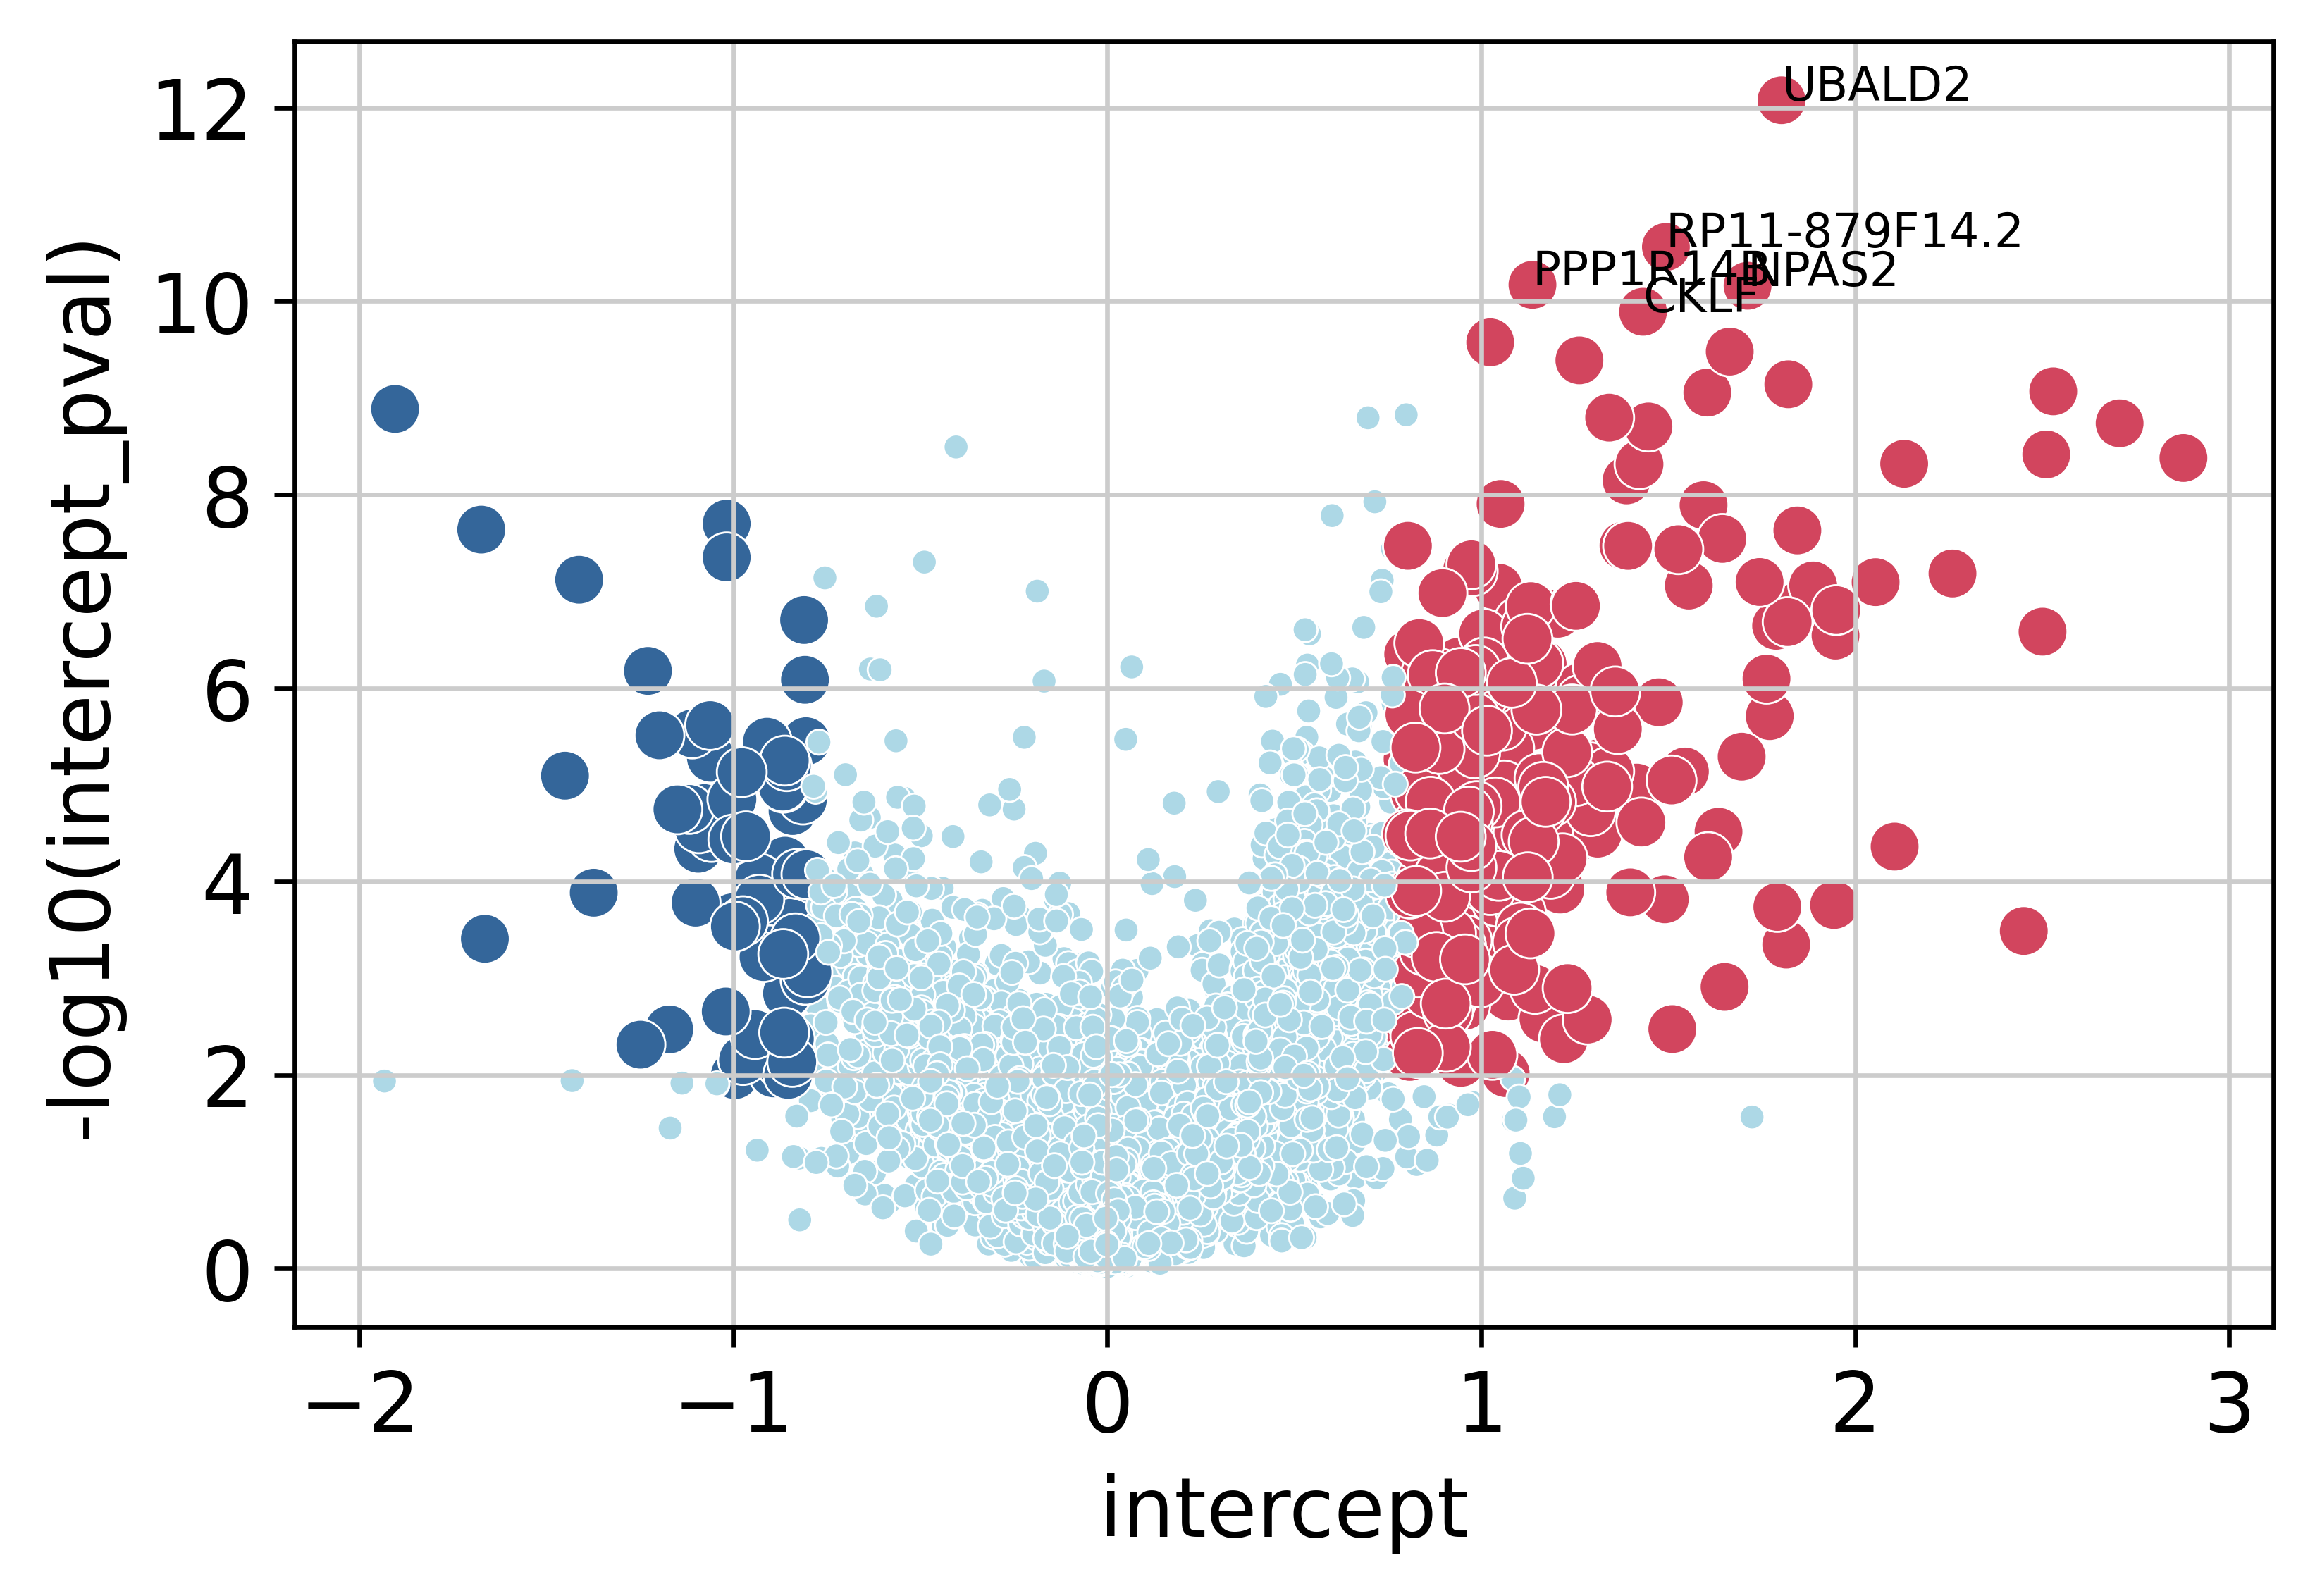

In [41]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.01, value_threshold=0.8)

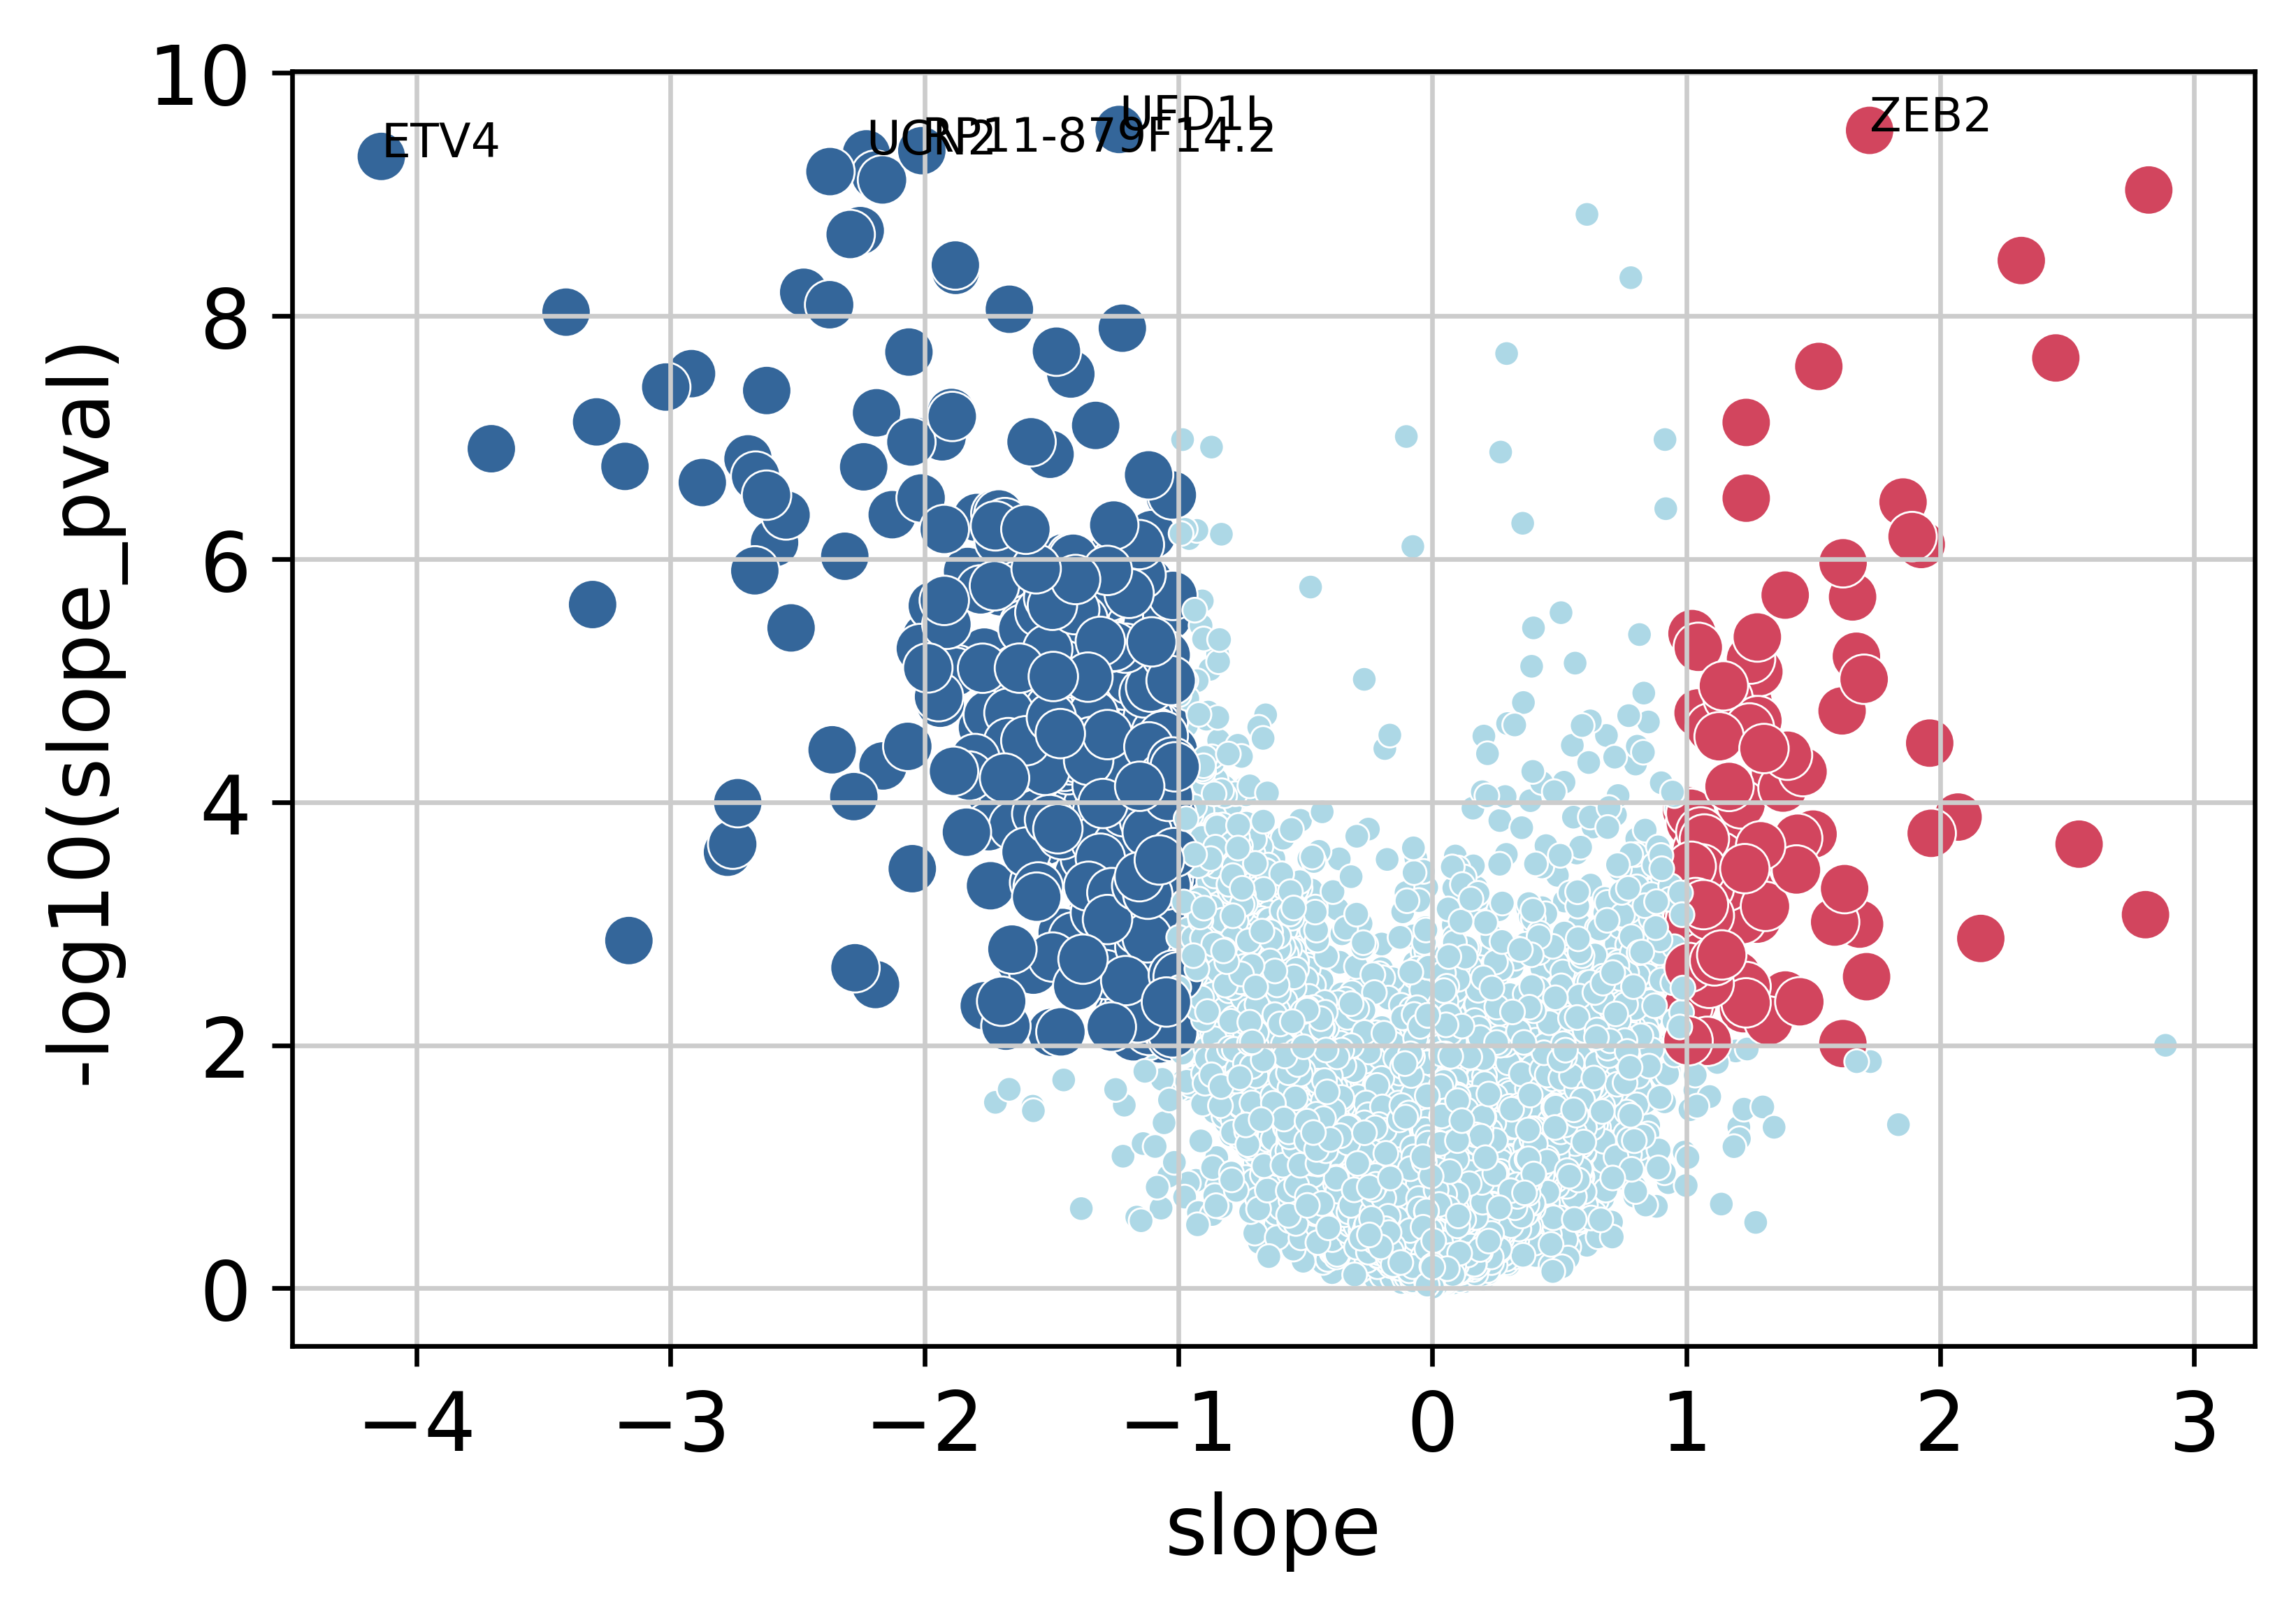

In [39]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.01, value_threshold=1)

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


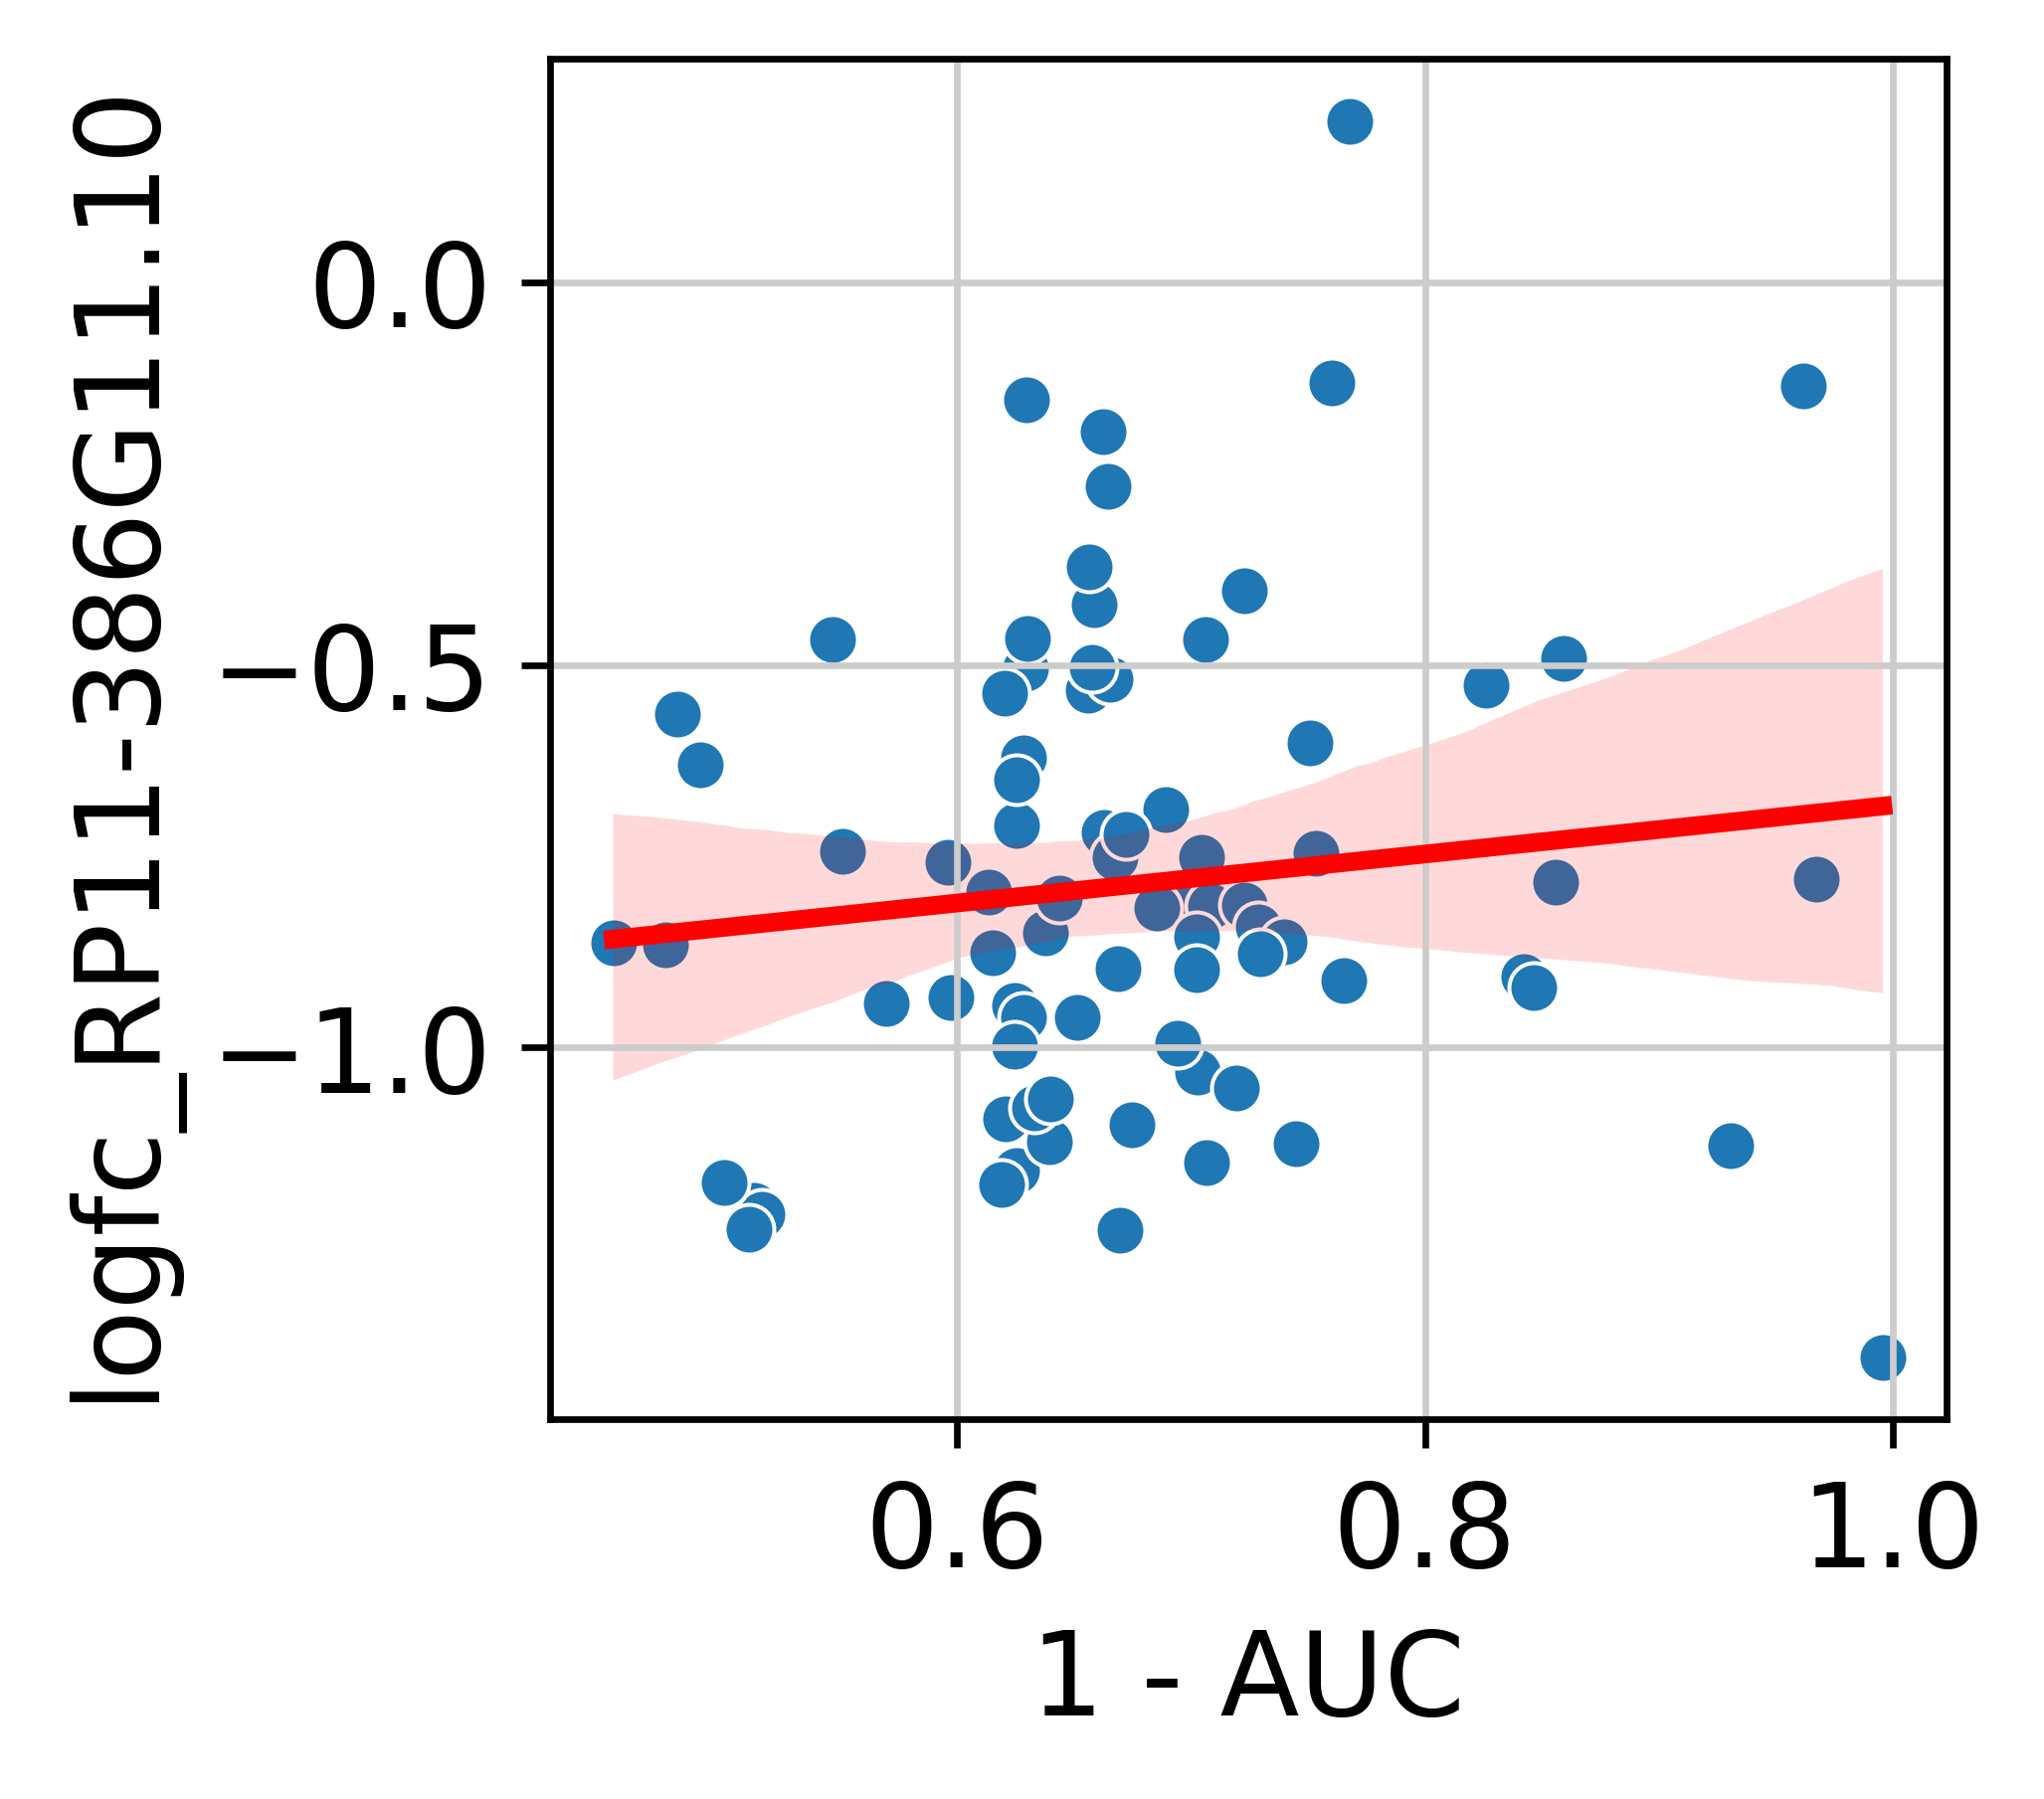

In [37]:
plot_example_linear_regression(adata, "Dabrafenib", "RP11-386G11.10", "1 - AUC", logfc_df_dabrafenib)

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


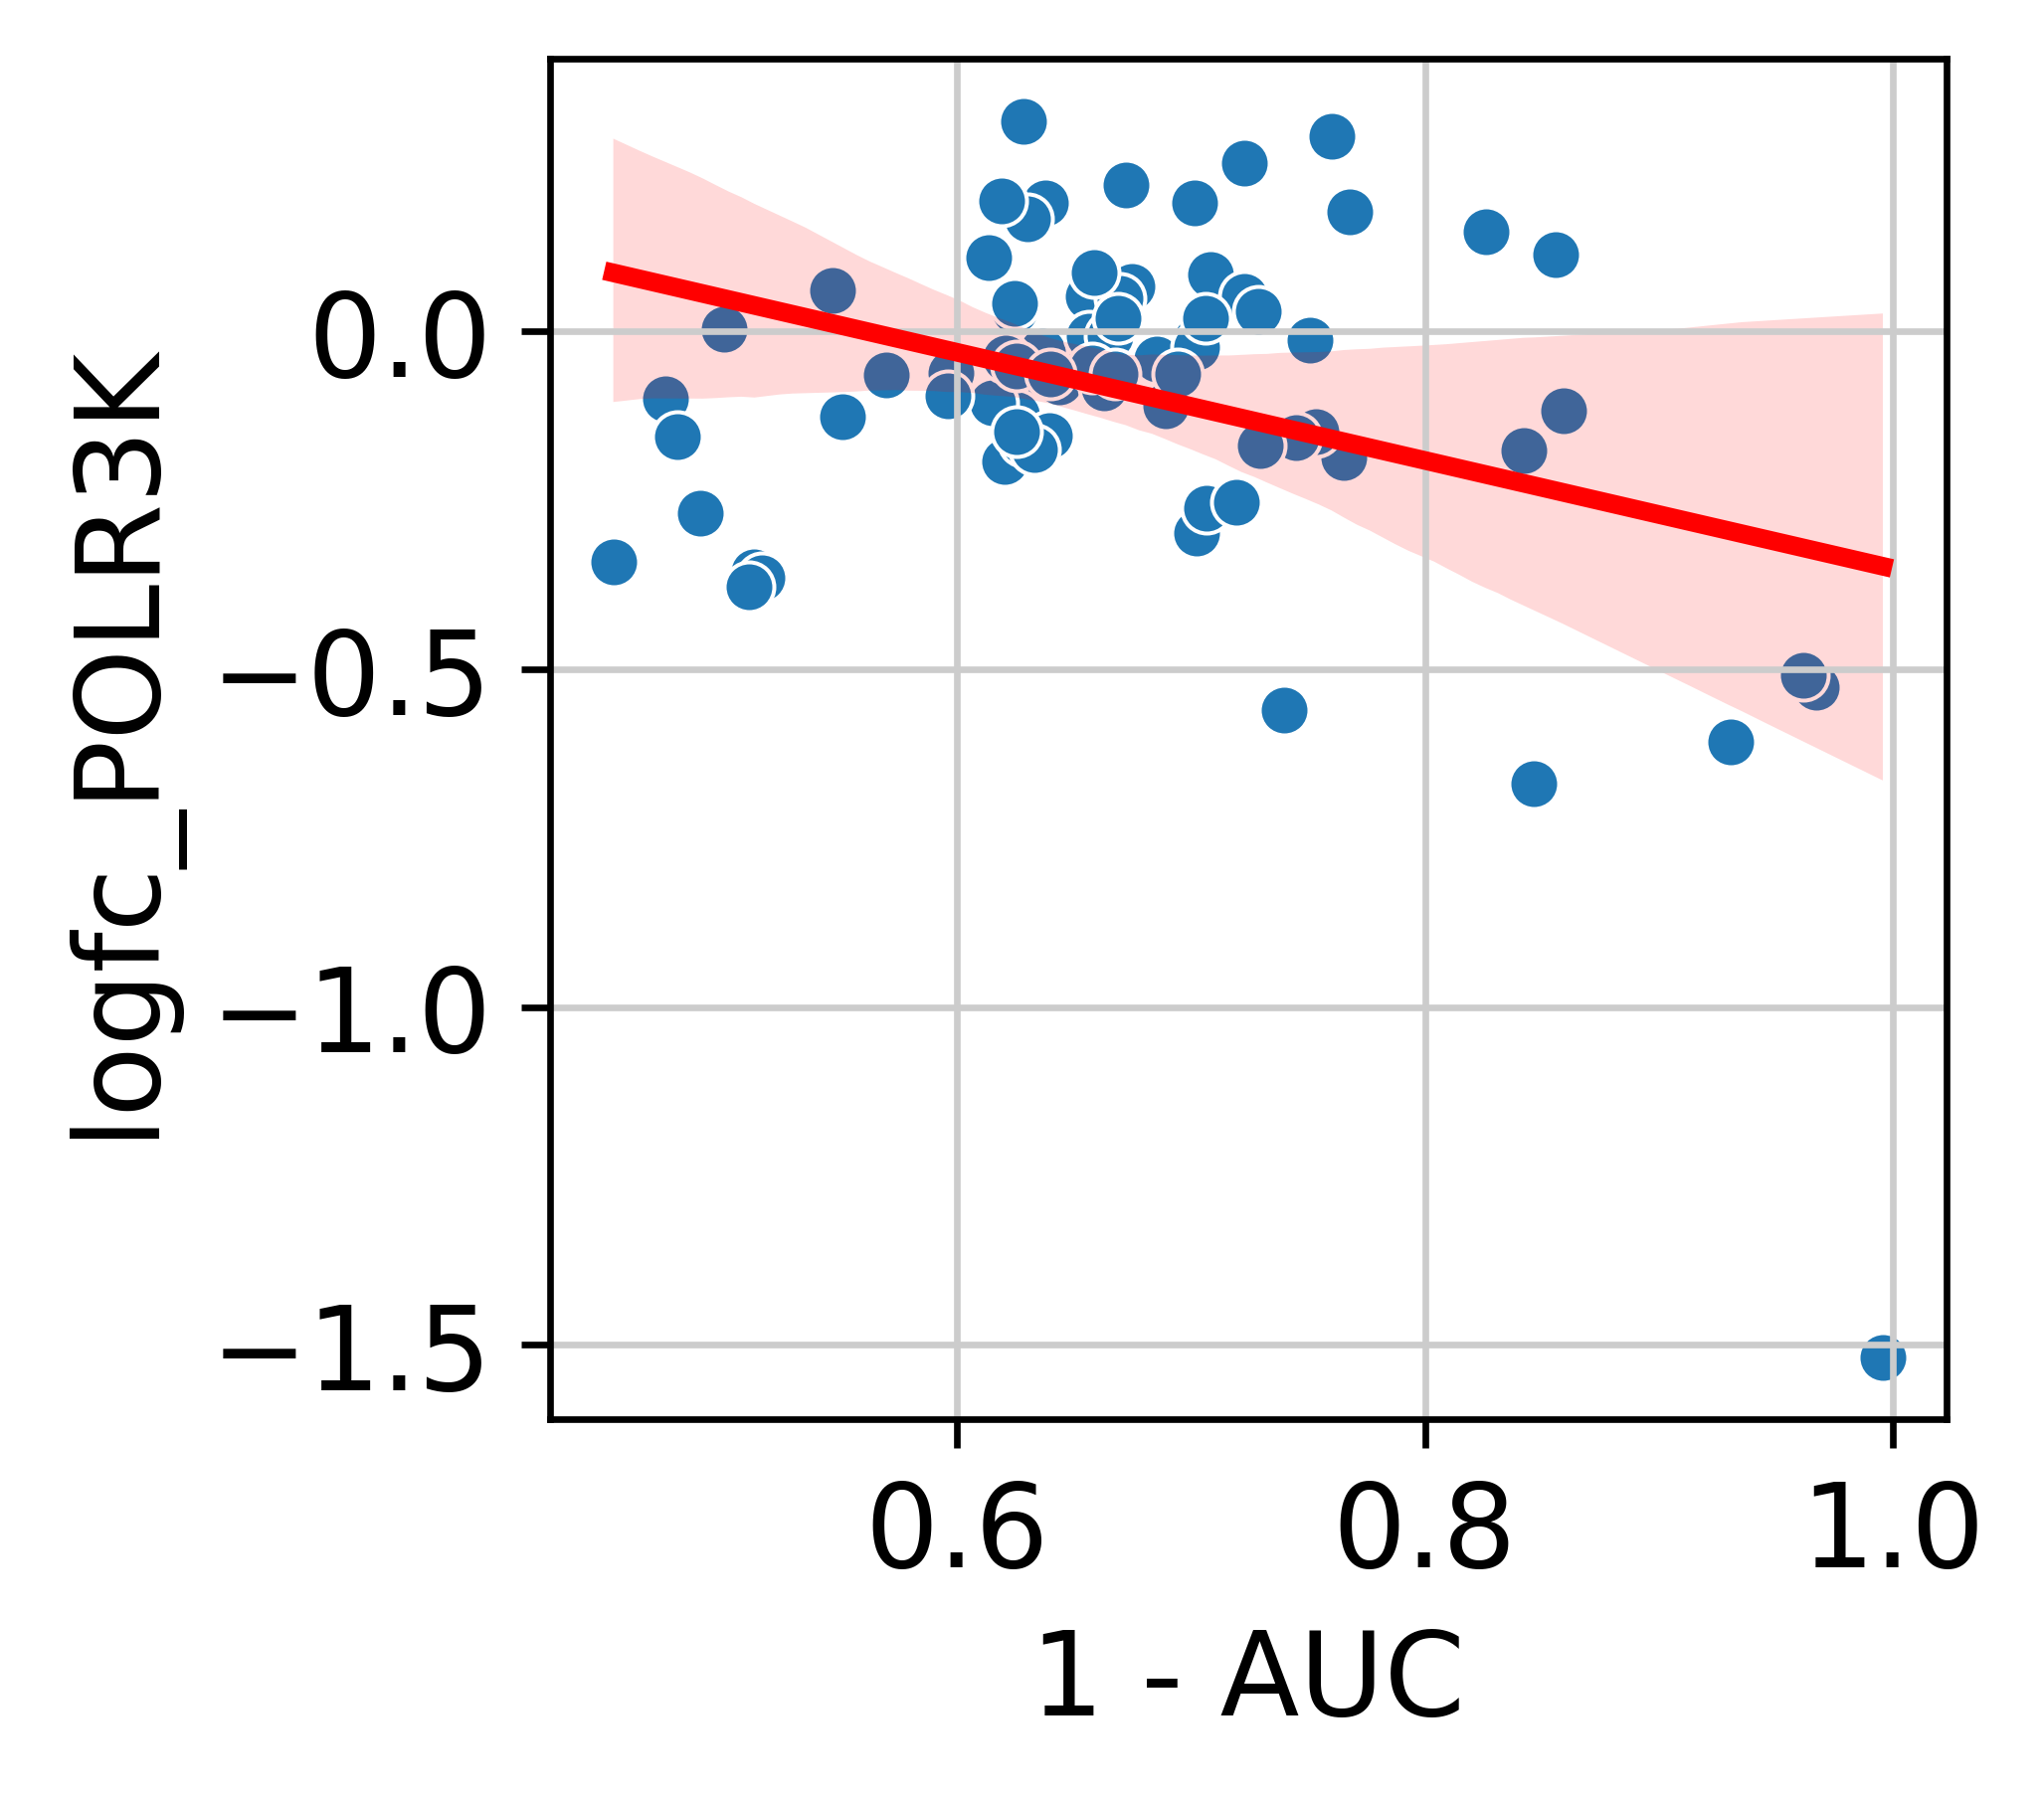

In [38]:
plot_example_linear_regression(adata, "Dabrafenib", "POLR3K", "1 - AUC", logfc_df_dabrafenib)

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


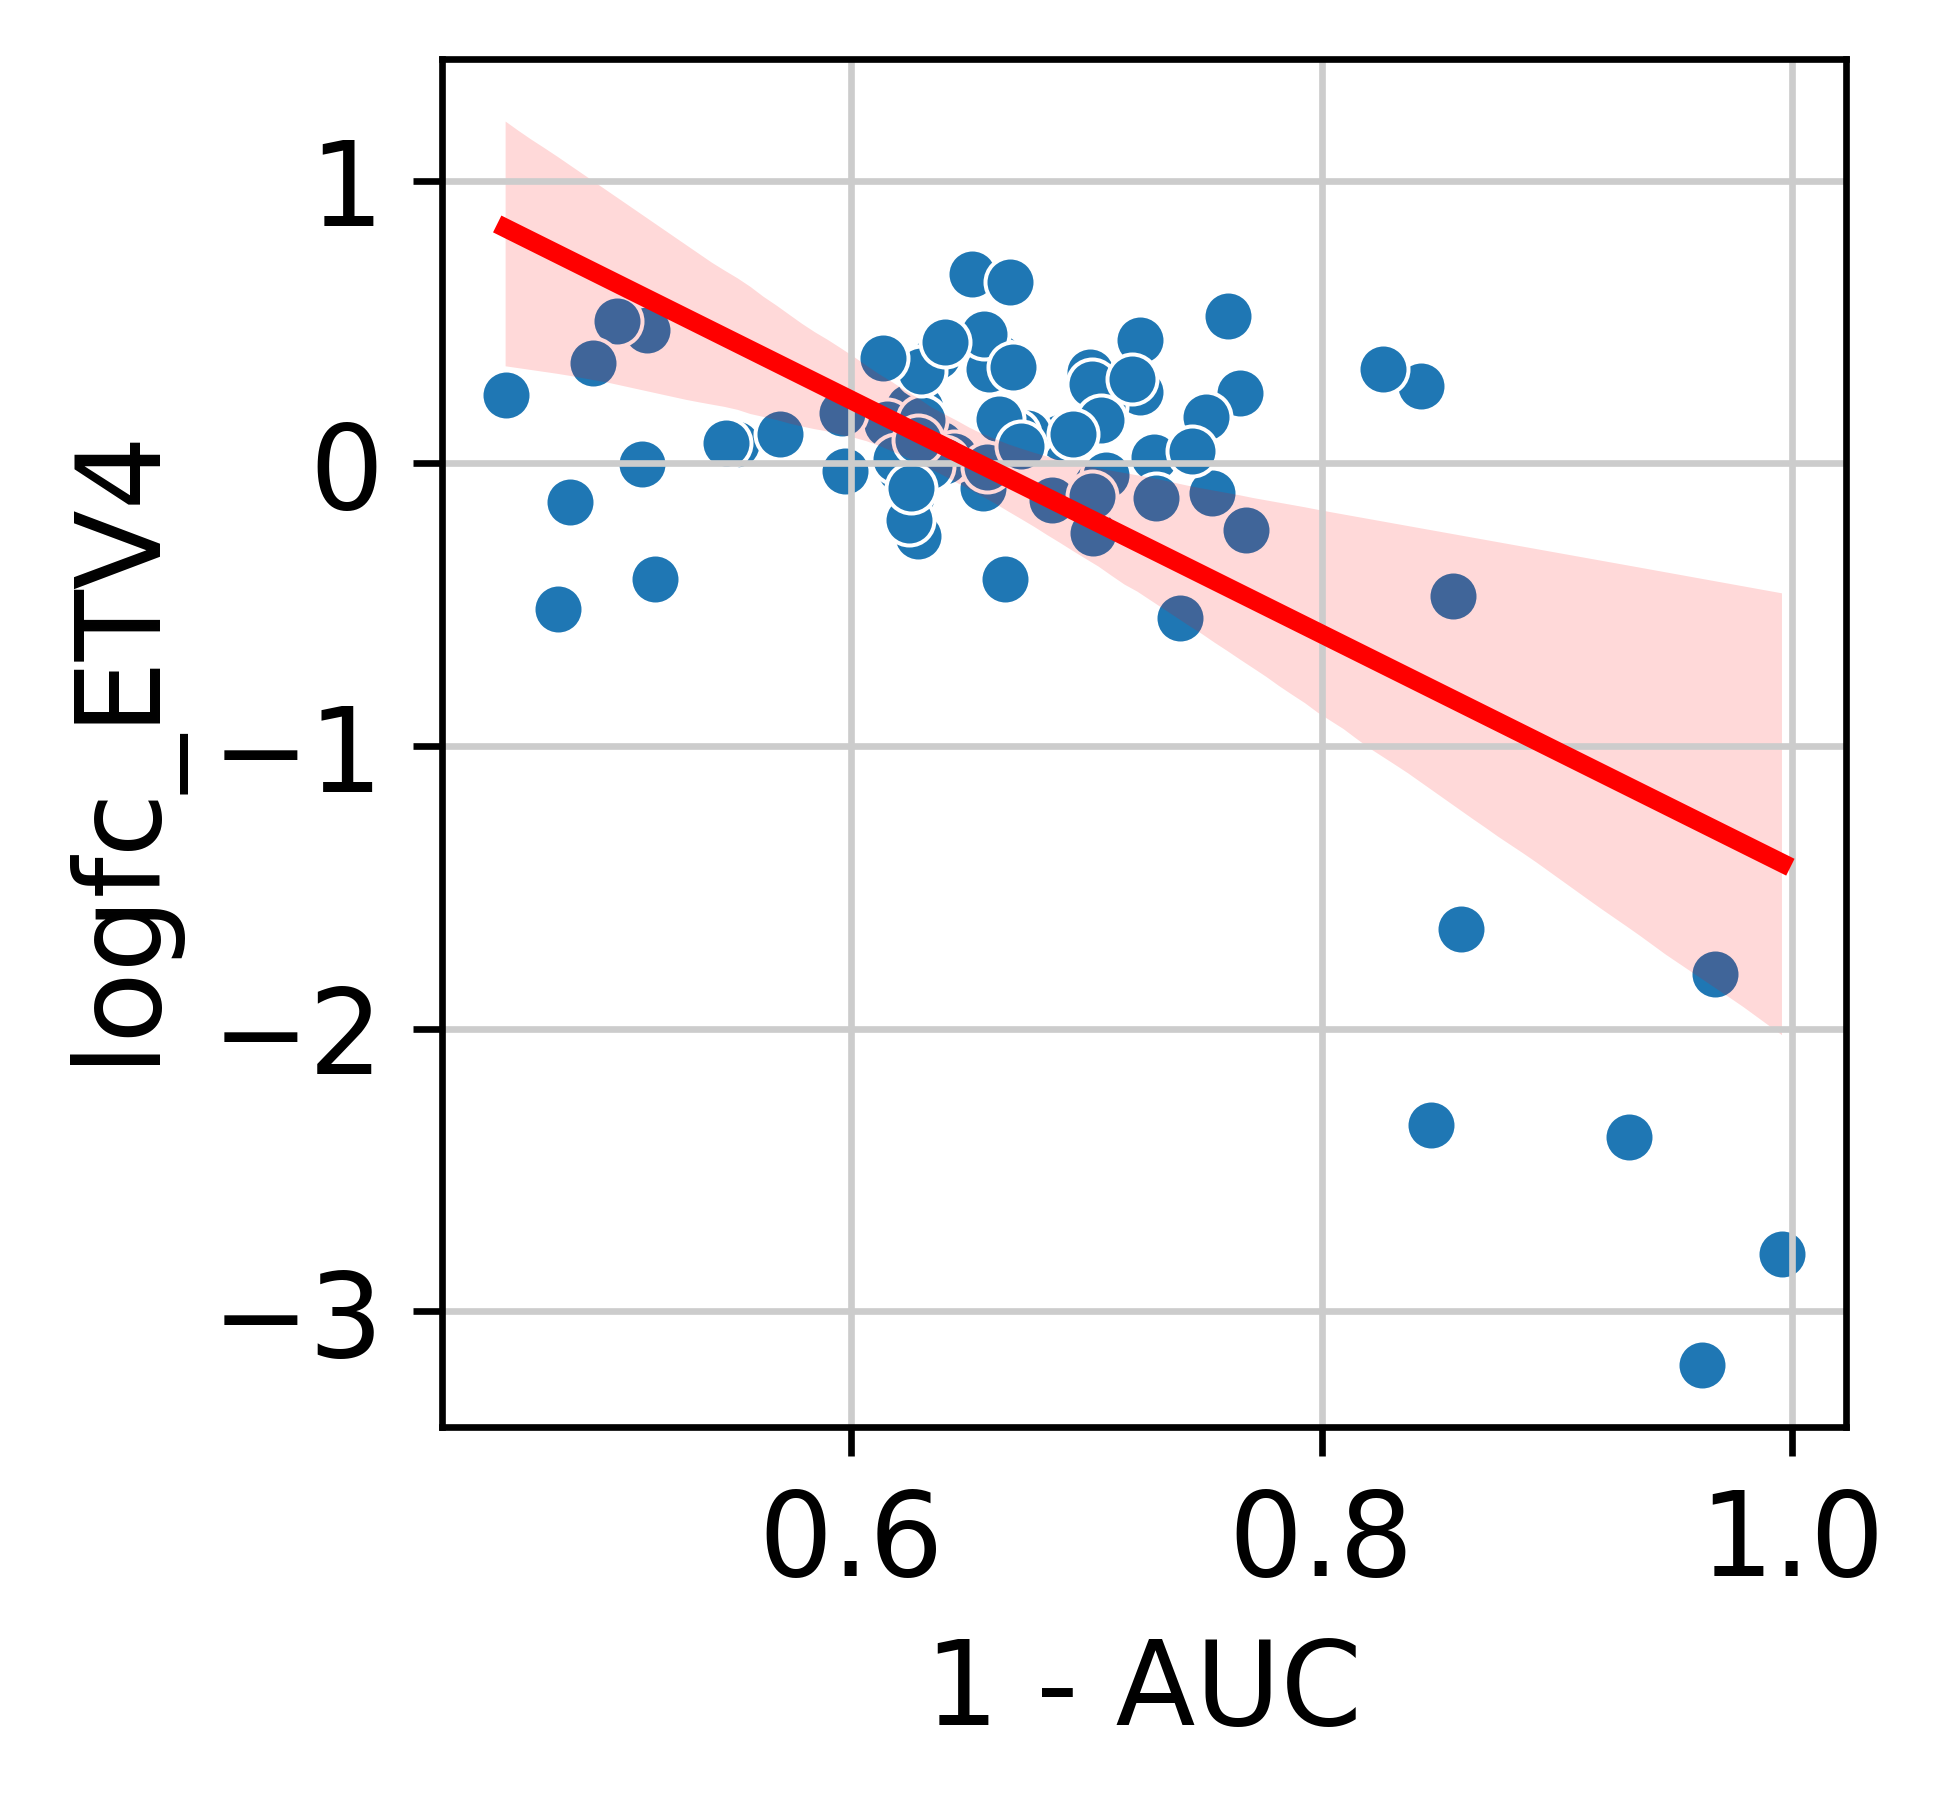

In [35]:
plot_example_linear_regression(adata, "Dabrafenib", "ETV4", "1 - AUC", logfc_df_dabrafenib)

In [43]:
lr_params_dabrafenib[(lr_params_dabrafenib["slope"] > 0.08) & (lr_params_dabrafenib["-log10(slope_pval)"] > 10)]

gene     slope  intercept    slope_pval  intercept_pval  \
FAM136A  FAM136A  0.099750  -0.453821  6.060119e-12    1.330250e-10   
POLR3K    POLR3K  0.106854  -0.564965  5.507538e-12    7.918018e-13   

         -log10(slope_pval)  -log10(intercept_pval) color  size  
FAM136A           11.217519                9.876067   red   1.1  
POLR3K            11.259043               12.101384   red   1.1

In [10]:
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - MoTrPAC_2023
16 - Kinase_Perturbations_from_GEO_down
17 - Disease_Signatures_from_GEO_down_2014
18 - Disease_Perturbations_from_GEO_up
19 - Old_CMAP_down
20 - MCF7_Perturbations_from_GEO_up
21 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
22 - PPI_Hub_Proteins
23 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
24 - Disease_Signatures_from_GEO_up_2014
25 - GTEx_Tissue_Expression_Up
26 - L1000_Kinase_a

Number of genes UP: 701, DOWN: 238
Number of pathways UP: 132, DOWN: 7


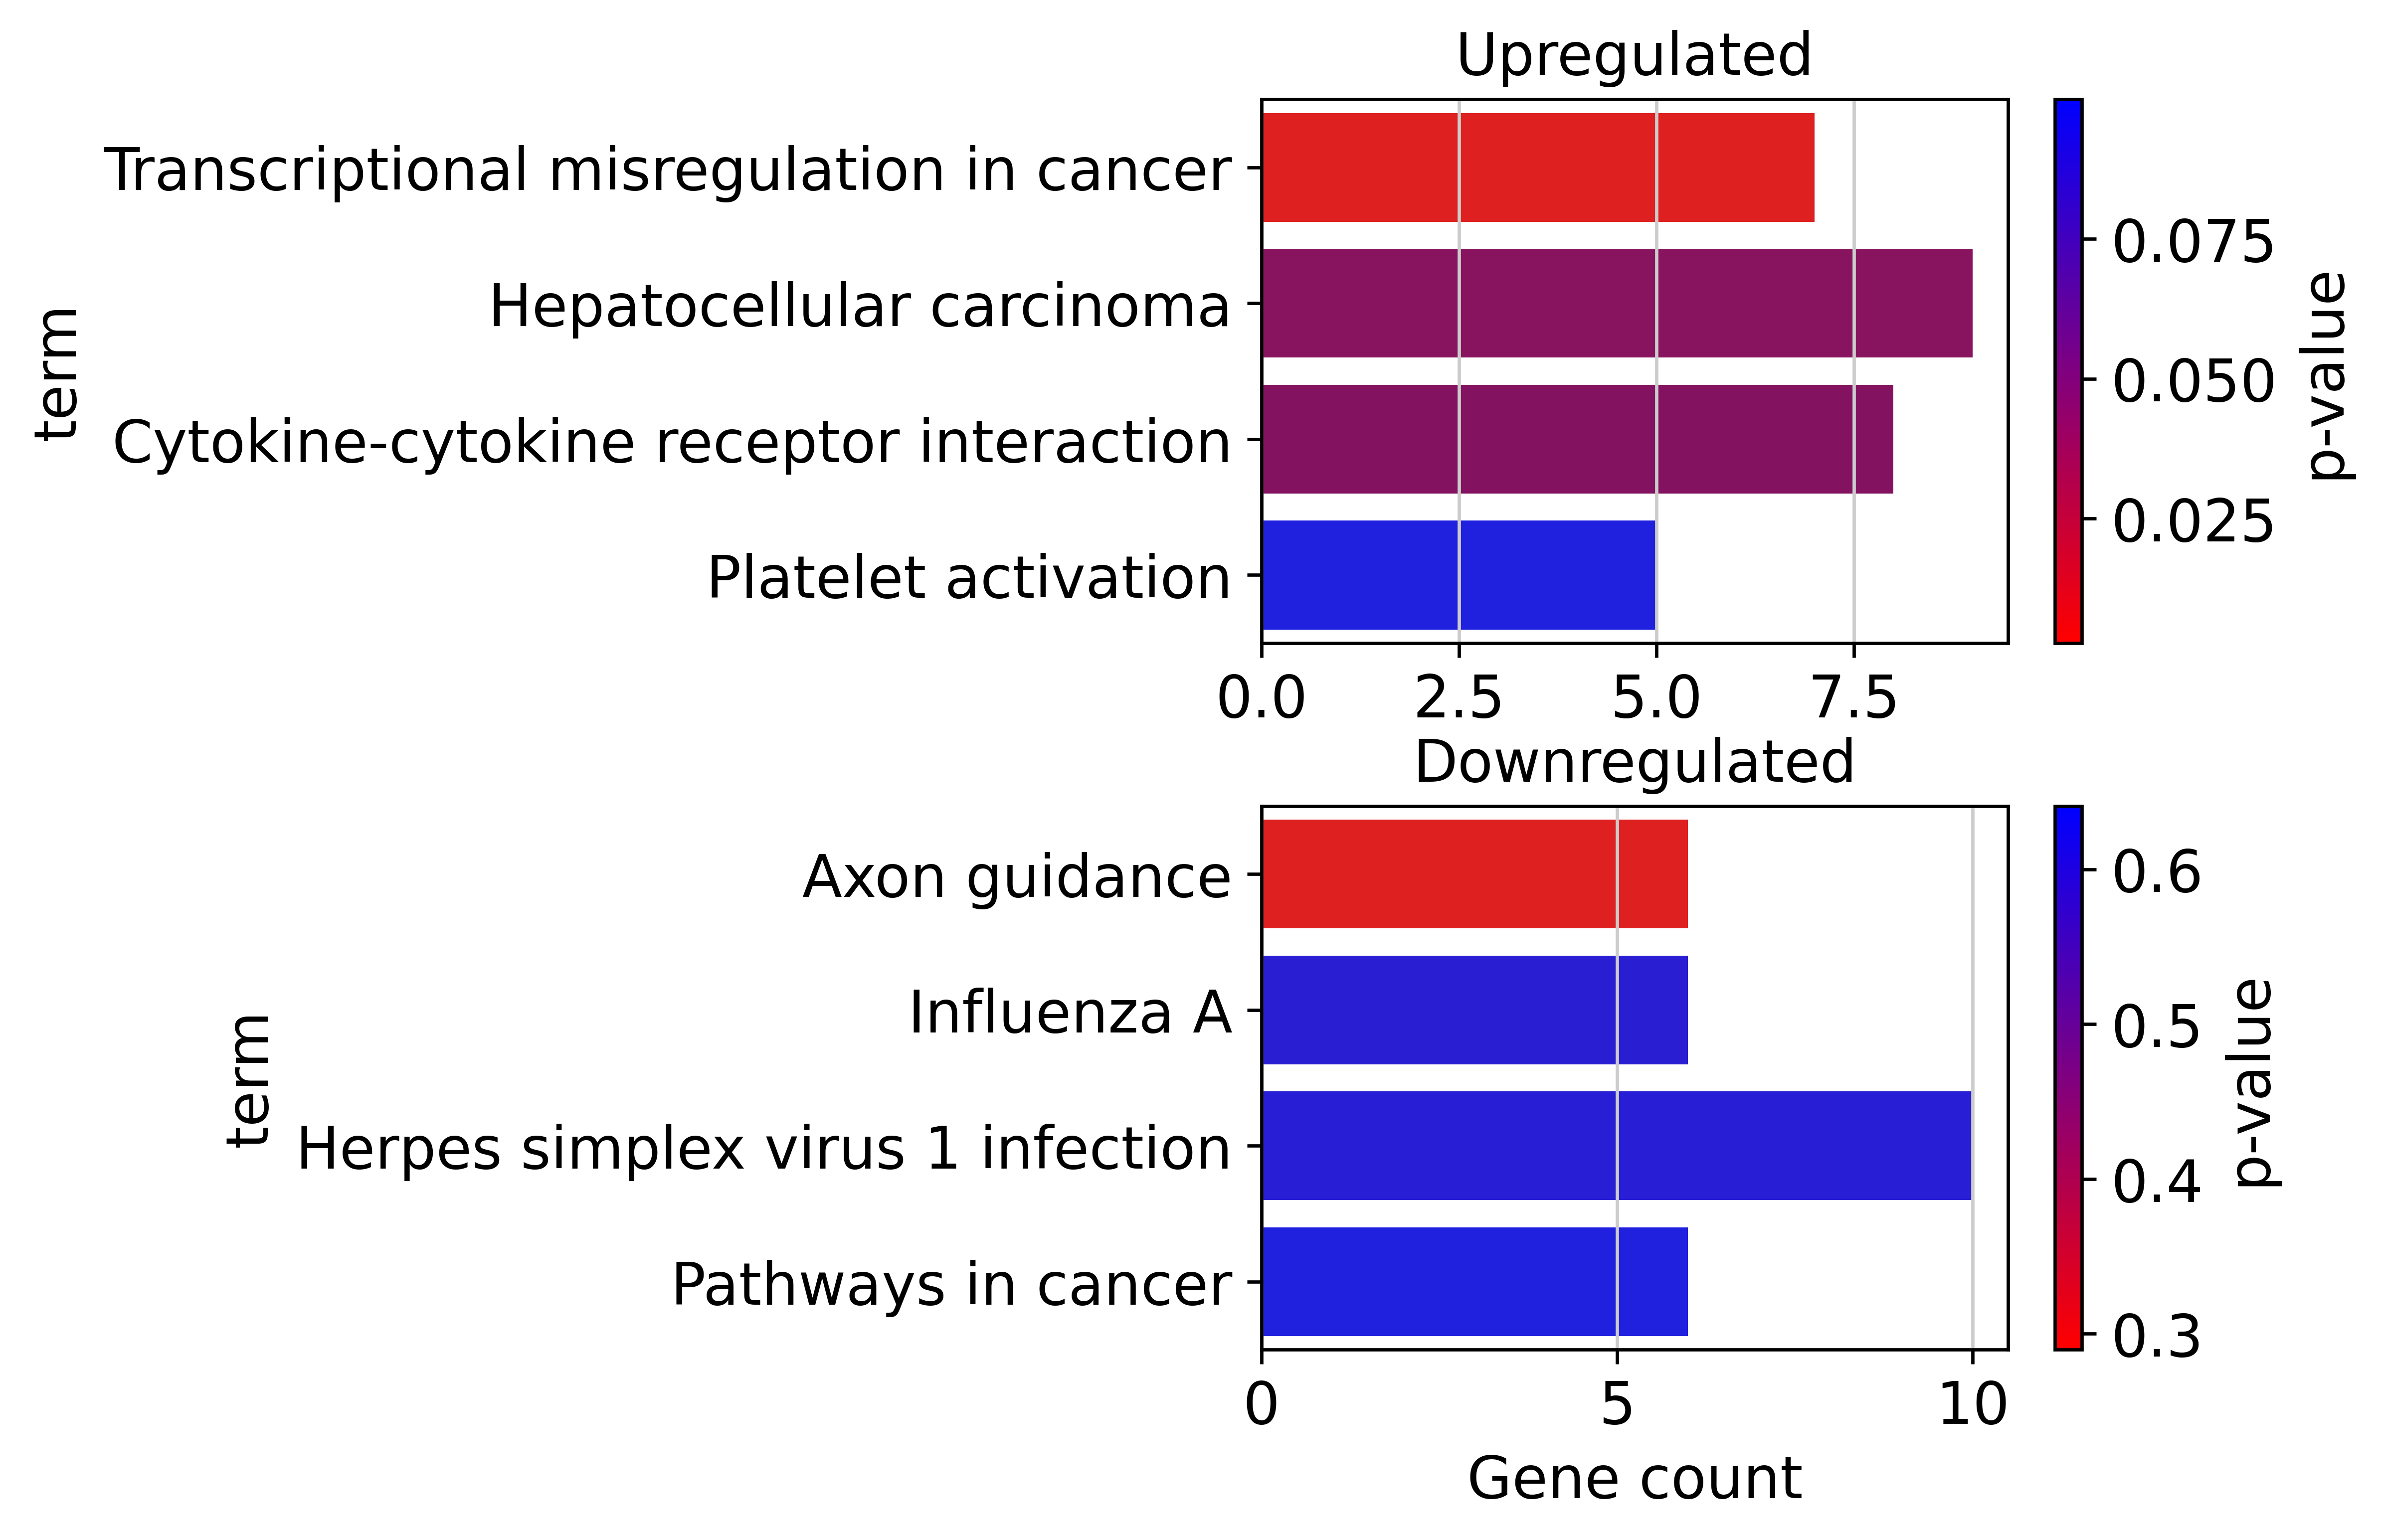

In [19]:
gsea(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.001, library="KEGG_2021_Human")

Number of genes UP: 215, DOWN: 735
Number of pathways UP: 5, DOWN: 140


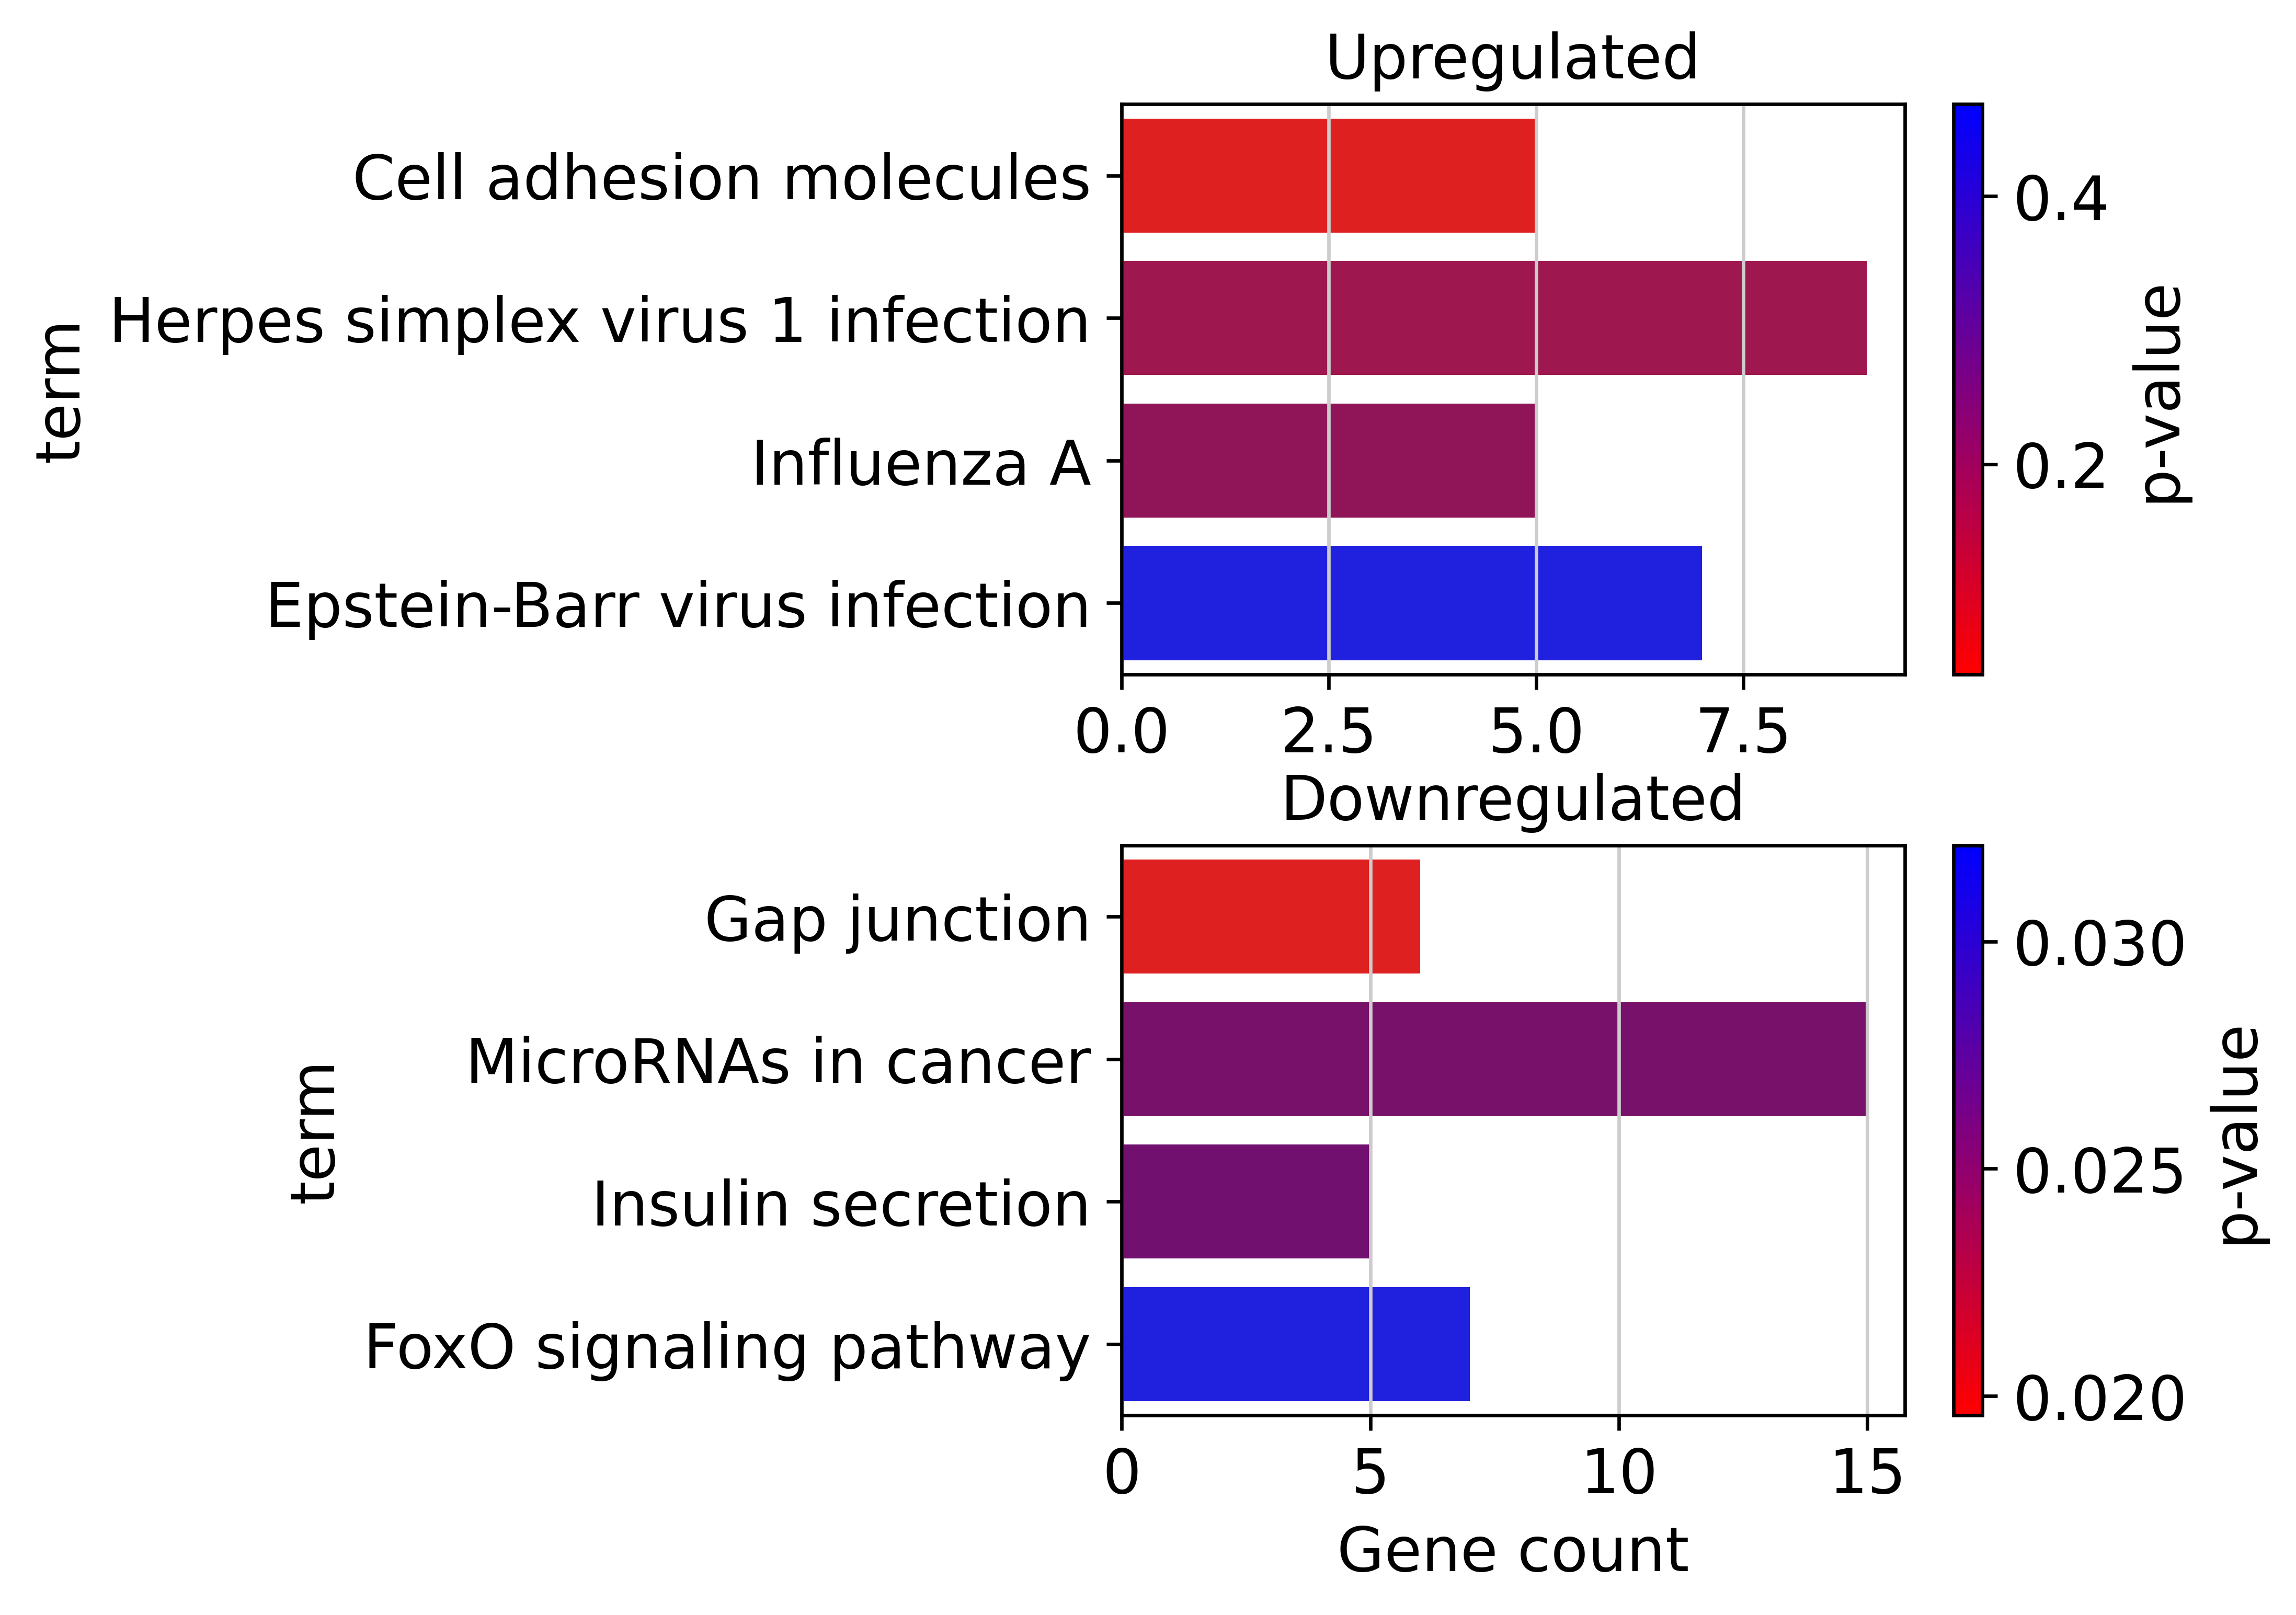

In [20]:
gsea(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.001, library="KEGG_2021_Human")

# Trametinib

In [19]:
#logfc_df_trametinib = comp_edger(adata, "Trametinib")
logfc_df_trametinib = pd.read_csv("mcfarland/output/logfc_df_trametinib.csv", index_col=0)
logfc_df_trametinib

MIR1302-10  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  AL627309.1  \
SIDM00139         0.0      0.0    0.0      0.013670           0.0   -0.035638   
SIDM00956         0.0      0.0    0.0     -0.005628           0.0   -0.032378   
SIDM00947         0.0      0.0    0.0     -0.025716           0.0   -0.041304   
SIDM00726         0.0      0.0    0.0      0.059869           0.0    0.024477   
SIDM00235         0.0      0.0    0.0      0.058846           0.0    0.003077   
...               ...      ...    ...           ...           ...         ...   
SIDM01055         0.0      0.0    0.0      0.000000           0.0    0.000000   
SIDM00909         0.0      0.0    0.0      0.000000           0.0    0.000000   
SIDM00564         0.0      0.0    0.0     -0.230564           0.0   -0.427998   
SIDM00575         0.0      0.0    0.0      0.000000           0.0    0.000000   
SIDM00756         0.0      0.0    0.0      0.218844           0.0    0.116864   

           RP11-34P13.14  RP11-34P13.9  AP006222.2  RP4-669L17.10  ...  \
SIDM00139            0.0           0.0    0.200579      -0.004455  ...   
SIDM00956            0.0           0.0    0.526867      -0.040614  ...   
SIDM00947            0.0           0.0   -0.074146      -0.038903  ...   
SIDM00726            0.0           0.0    0.304163       0.000000  ...   
SIDM00235            0.0           0.0    0.301462      -0.014199  ...   
...                  ...           ...         ...            ...  ...   
SIDM01055            0.0           0.0   -0.684194       0.269435  ...   
SIDM00909            0.0           0.0    0.116314       0.000000  ...   
SIDM00564            0.0           0.0    0.145299       0.000000  ...   
SIDM00575            0.0           0.0    0.501901       0.000000  ...   
SIDM00756            0.0           0.0   -0.212416       0.000000  ...   

           KIR3DL2-1  AL590523.1  CT476828.1   PNRC2-1  SRSF10-1  AC145205.1  \
SIDM00139        0.0         0.0         0.0  0.071283 -0.107314         0.0   
SIDM00956        0.0         0.0         0.0 -0.050723 -0.069216         0.0   
SIDM00947        0.0         0.0         0.0  0.053517  0.088853         0.0   
SIDM00726        0.0         0.0         0.0 -0.061378  0.008453         0.0   
SIDM00235        0.0         0.0         0.0 -0.022942  0.373510         0.0   
...              ...         ...         ...       ...       ...         ...   
SIDM01055        0.0         0.0         0.0  0.140932 -0.045569         0.0   
SIDM00909        0.0         0.0         0.0 -0.154563 -0.469799         0.0   
SIDM00564        0.0         0.0         0.0  0.199462  0.518099         0.0   
SIDM00575        0.0         0.0         0.0  0.000000  0.189748         0.0   
SIDM00756        0.0         0.0         0.0  0.046040  0.347616         0.0   

           BAGE5  CU459201.1  AC002321.2  AC002321.1  
SIDM00139    0.0    0.000000         0.0         0.0  
SIDM00956    0.0   -0.008534         0.0         0.0  
SIDM00947    0.0    0.000000         0.0         0.0  
SIDM00726    0.0    0.000000         0.0         0.0  
SIDM00235    0.0    0.000000         0.0         0.0  
...          ...         ...         ...         ...  
SIDM01055    0.0    0.000000         0.0         0.0  
SIDM00909    0.0    0.000000         0.0         0.0  
SIDM00564    0.0    0.000000         0.0         0.0  
SIDM00575    0.0    0.000000         0.0         0.0  
SIDM00756    0.0    0.000000         0.0         0.0  

[109 rows x 32738 columns]

In [22]:
lr_params_trametinib = comp_linear_regression(adata, perturbation="Trametinib", auc_col="1 - AUC", logfc_df=logfc_df_trametinib)
lr_params_trametinib.to_csv("mcfarland/output/linear_regression_AUC_results_trametinib.csv")

perturbation
Trametinib    41300
control       29143
Name: count, dtype: int64


  0%|                                                                                                                                                                                                                                       | 0/32738 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32738/32738 [03:10<00:00, 171.40it/s]


In [24]:
#lr_params_trametinib = pd.read_csv("mcfarland/output/linear_regression_AUC_results_trametinib.csv", index_col=0)
lr_params_trametinib

gene         slope     intercept  slope_pval  \
MIR1302-10      MIR1302-10  4.193872e-03 -3.105716e-03    0.196499   
FAM138A            FAM138A  3.240062e-17 -2.661387e-17    0.943115   
OR4F5                OR4F5  3.240062e-17 -2.661387e-17    0.943115   
RP11-34P13.7  RP11-34P13.7  2.699075e-02 -2.551147e-02    0.713308   
RP11-34P13.8  RP11-34P13.8 -1.511323e-02  1.373543e-02    0.089116   
...                    ...           ...           ...         ...   
AC145205.1      AC145205.1 -2.028403e-03  1.800856e-03    0.456726   
BAGE5                BAGE5 -7.116029e-03  6.260402e-03    0.072473   
CU459201.1      CU459201.1  3.267863e-04 -3.467156e-04    0.663984   
AC002321.2      AC002321.2  3.240062e-17 -2.661387e-17    0.943115   
AC002321.1      AC002321.1  3.240062e-17 -2.661387e-17    0.943115   

              intercept_pval  -log10(slope_pval)  -log10(intercept_pval)  
MIR1302-10          0.247688            0.706639                0.606095  
FAM138A             0.943571            0.025435                0.025225  
OR4F5               0.943571            0.025435                0.025225  
RP11-34P13.7        0.674958            0.146723                0.170723  
RP11-34P13.8        0.062409            1.050046                1.204750  
...                      ...                 ...                     ...  
AC145205.1          0.424980            0.340345                0.371632  
BAGE5               0.056591            1.139824                1.247252  
CU459201.1          0.577894            0.177842                0.238151  
AC002321.2          0.943571            0.025435                0.025225  
AC002321.1          0.943571            0.025435                0.025225  

[32738 rows x 7 columns]

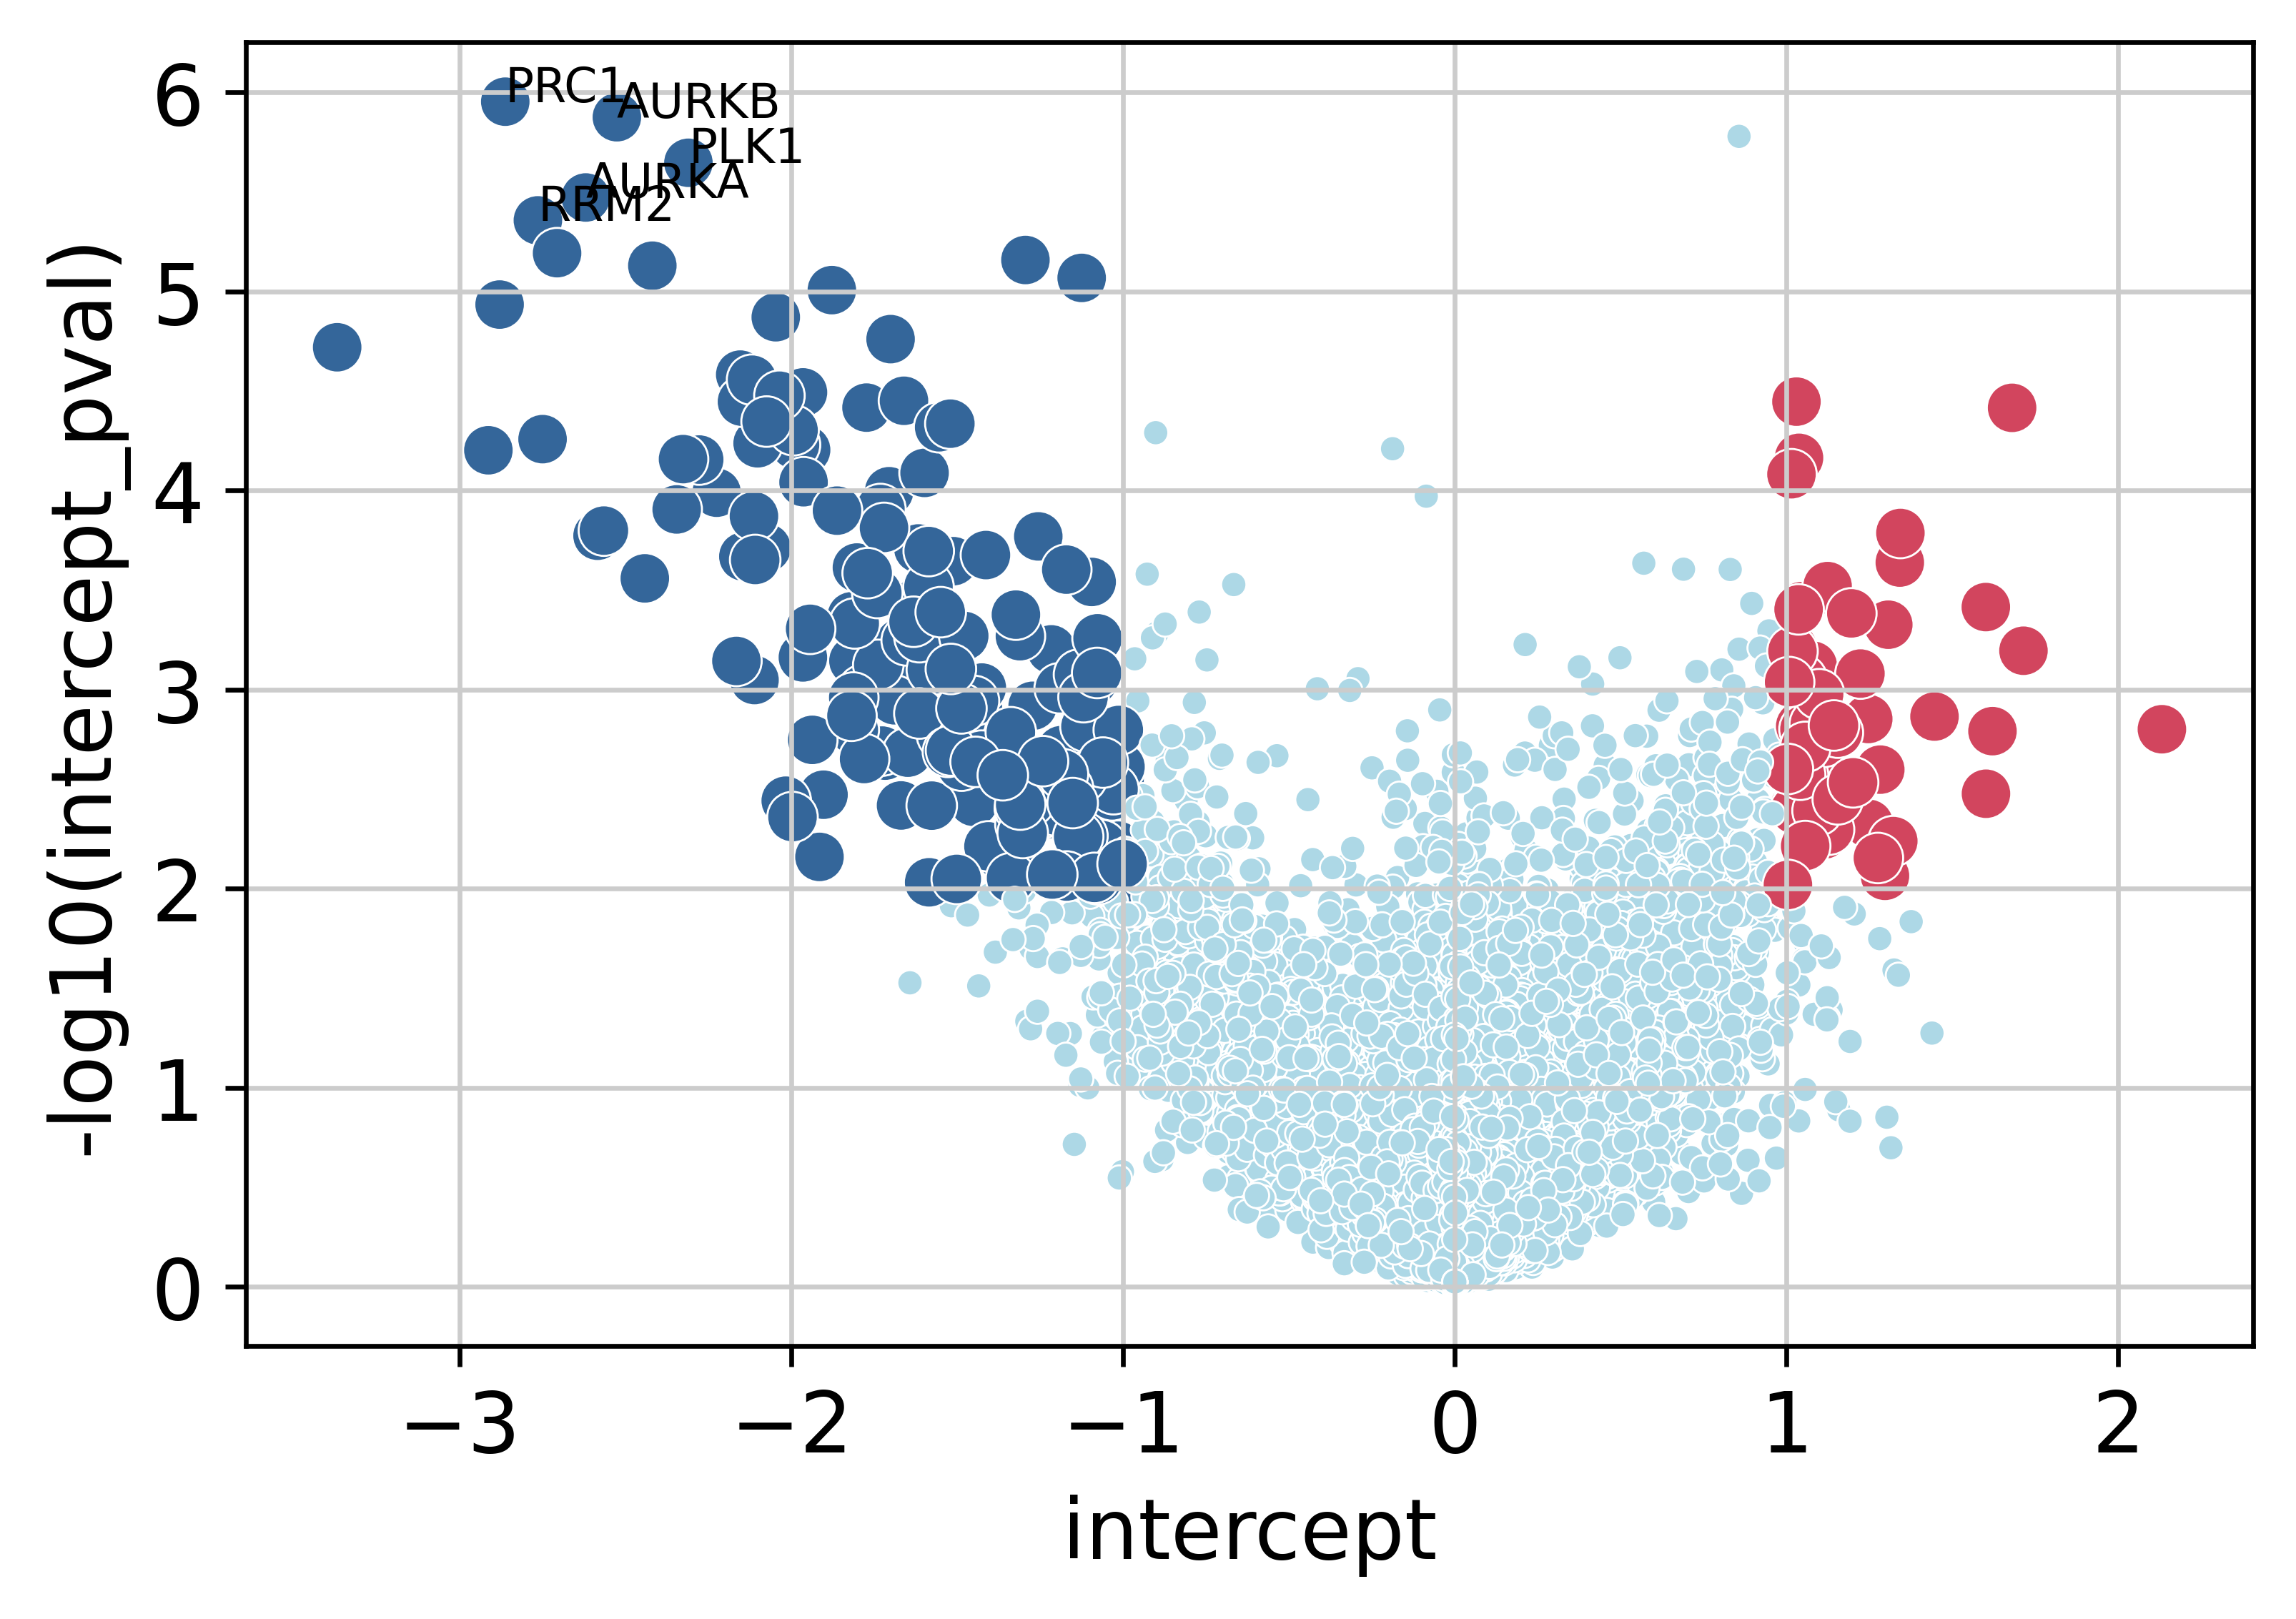

In [25]:
volcano_plot(lr_params_trametinib, "Trametinib", "intercept", pval_threshold=0.01, value_threshold=1)

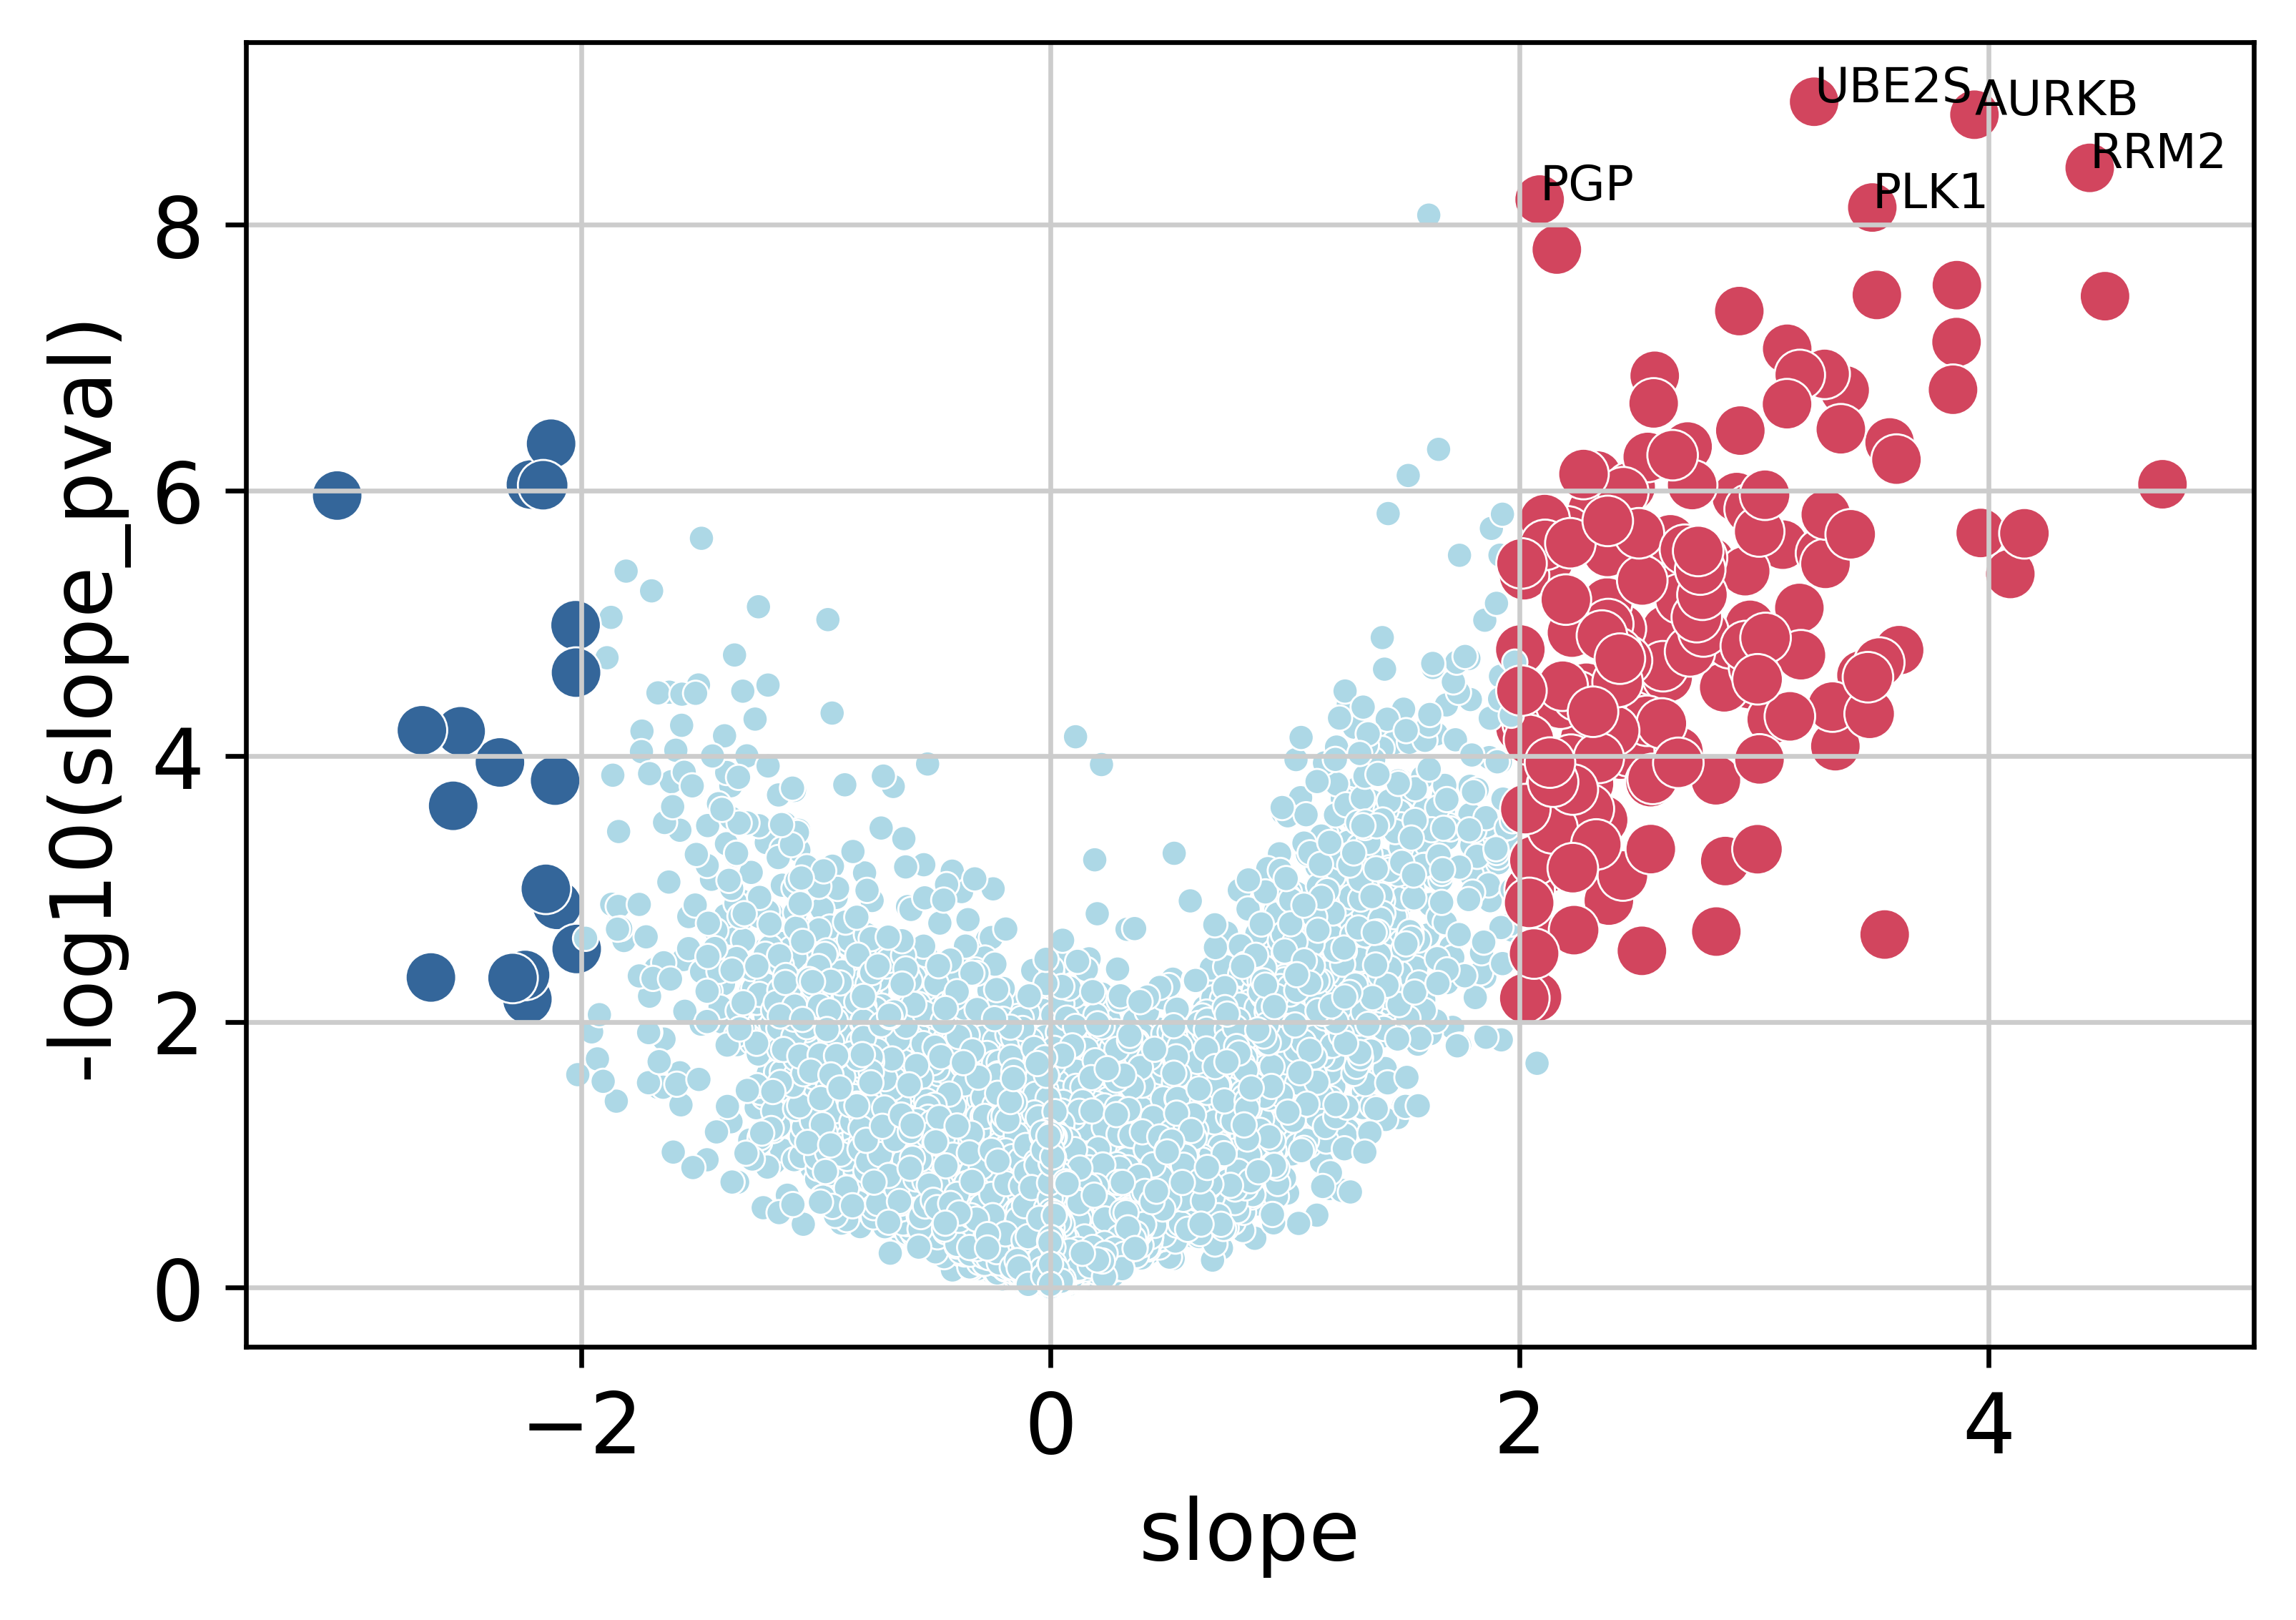

In [26]:
volcano_plot(lr_params_trametinib, "Trametinib", "slope", pval_threshold=0.01, value_threshold=2)

perturbation
Trametinib    41300
control       29143
Name: count, dtype: int64


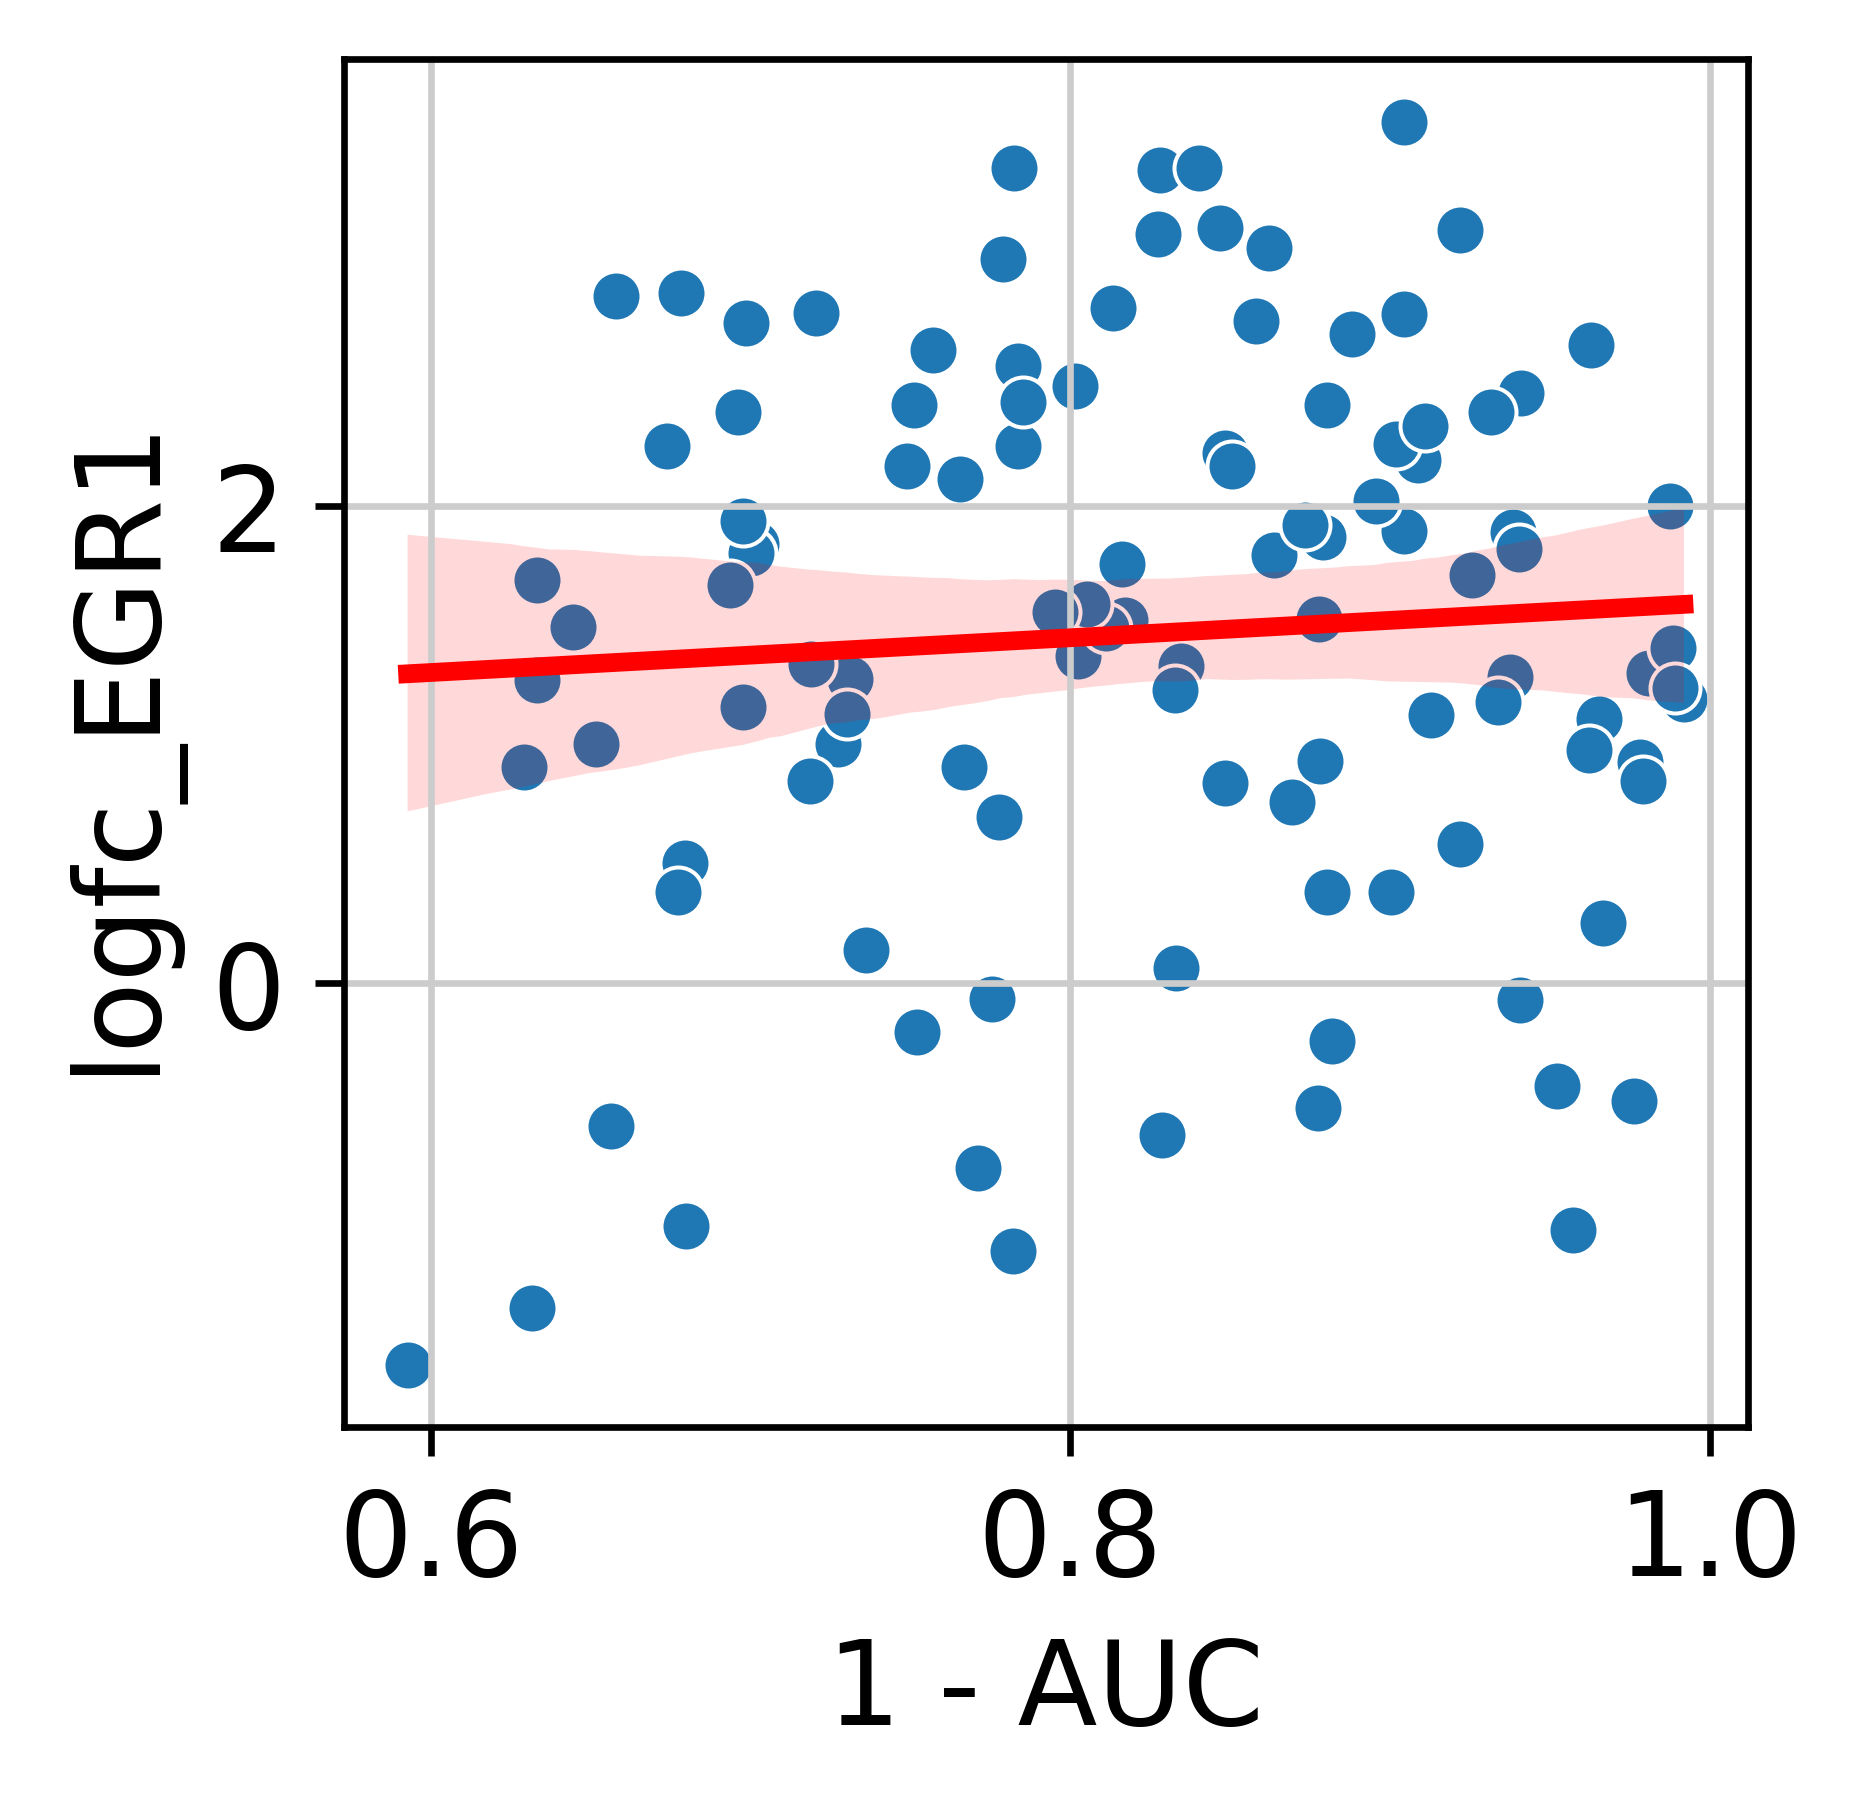

In [27]:
plot_example_linear_regression(adata, "Trametinib", "EGR1", "1 - AUC", logfc_df_trametinib)

perturbation
Trametinib    41300
control       29143
Name: count, dtype: int64


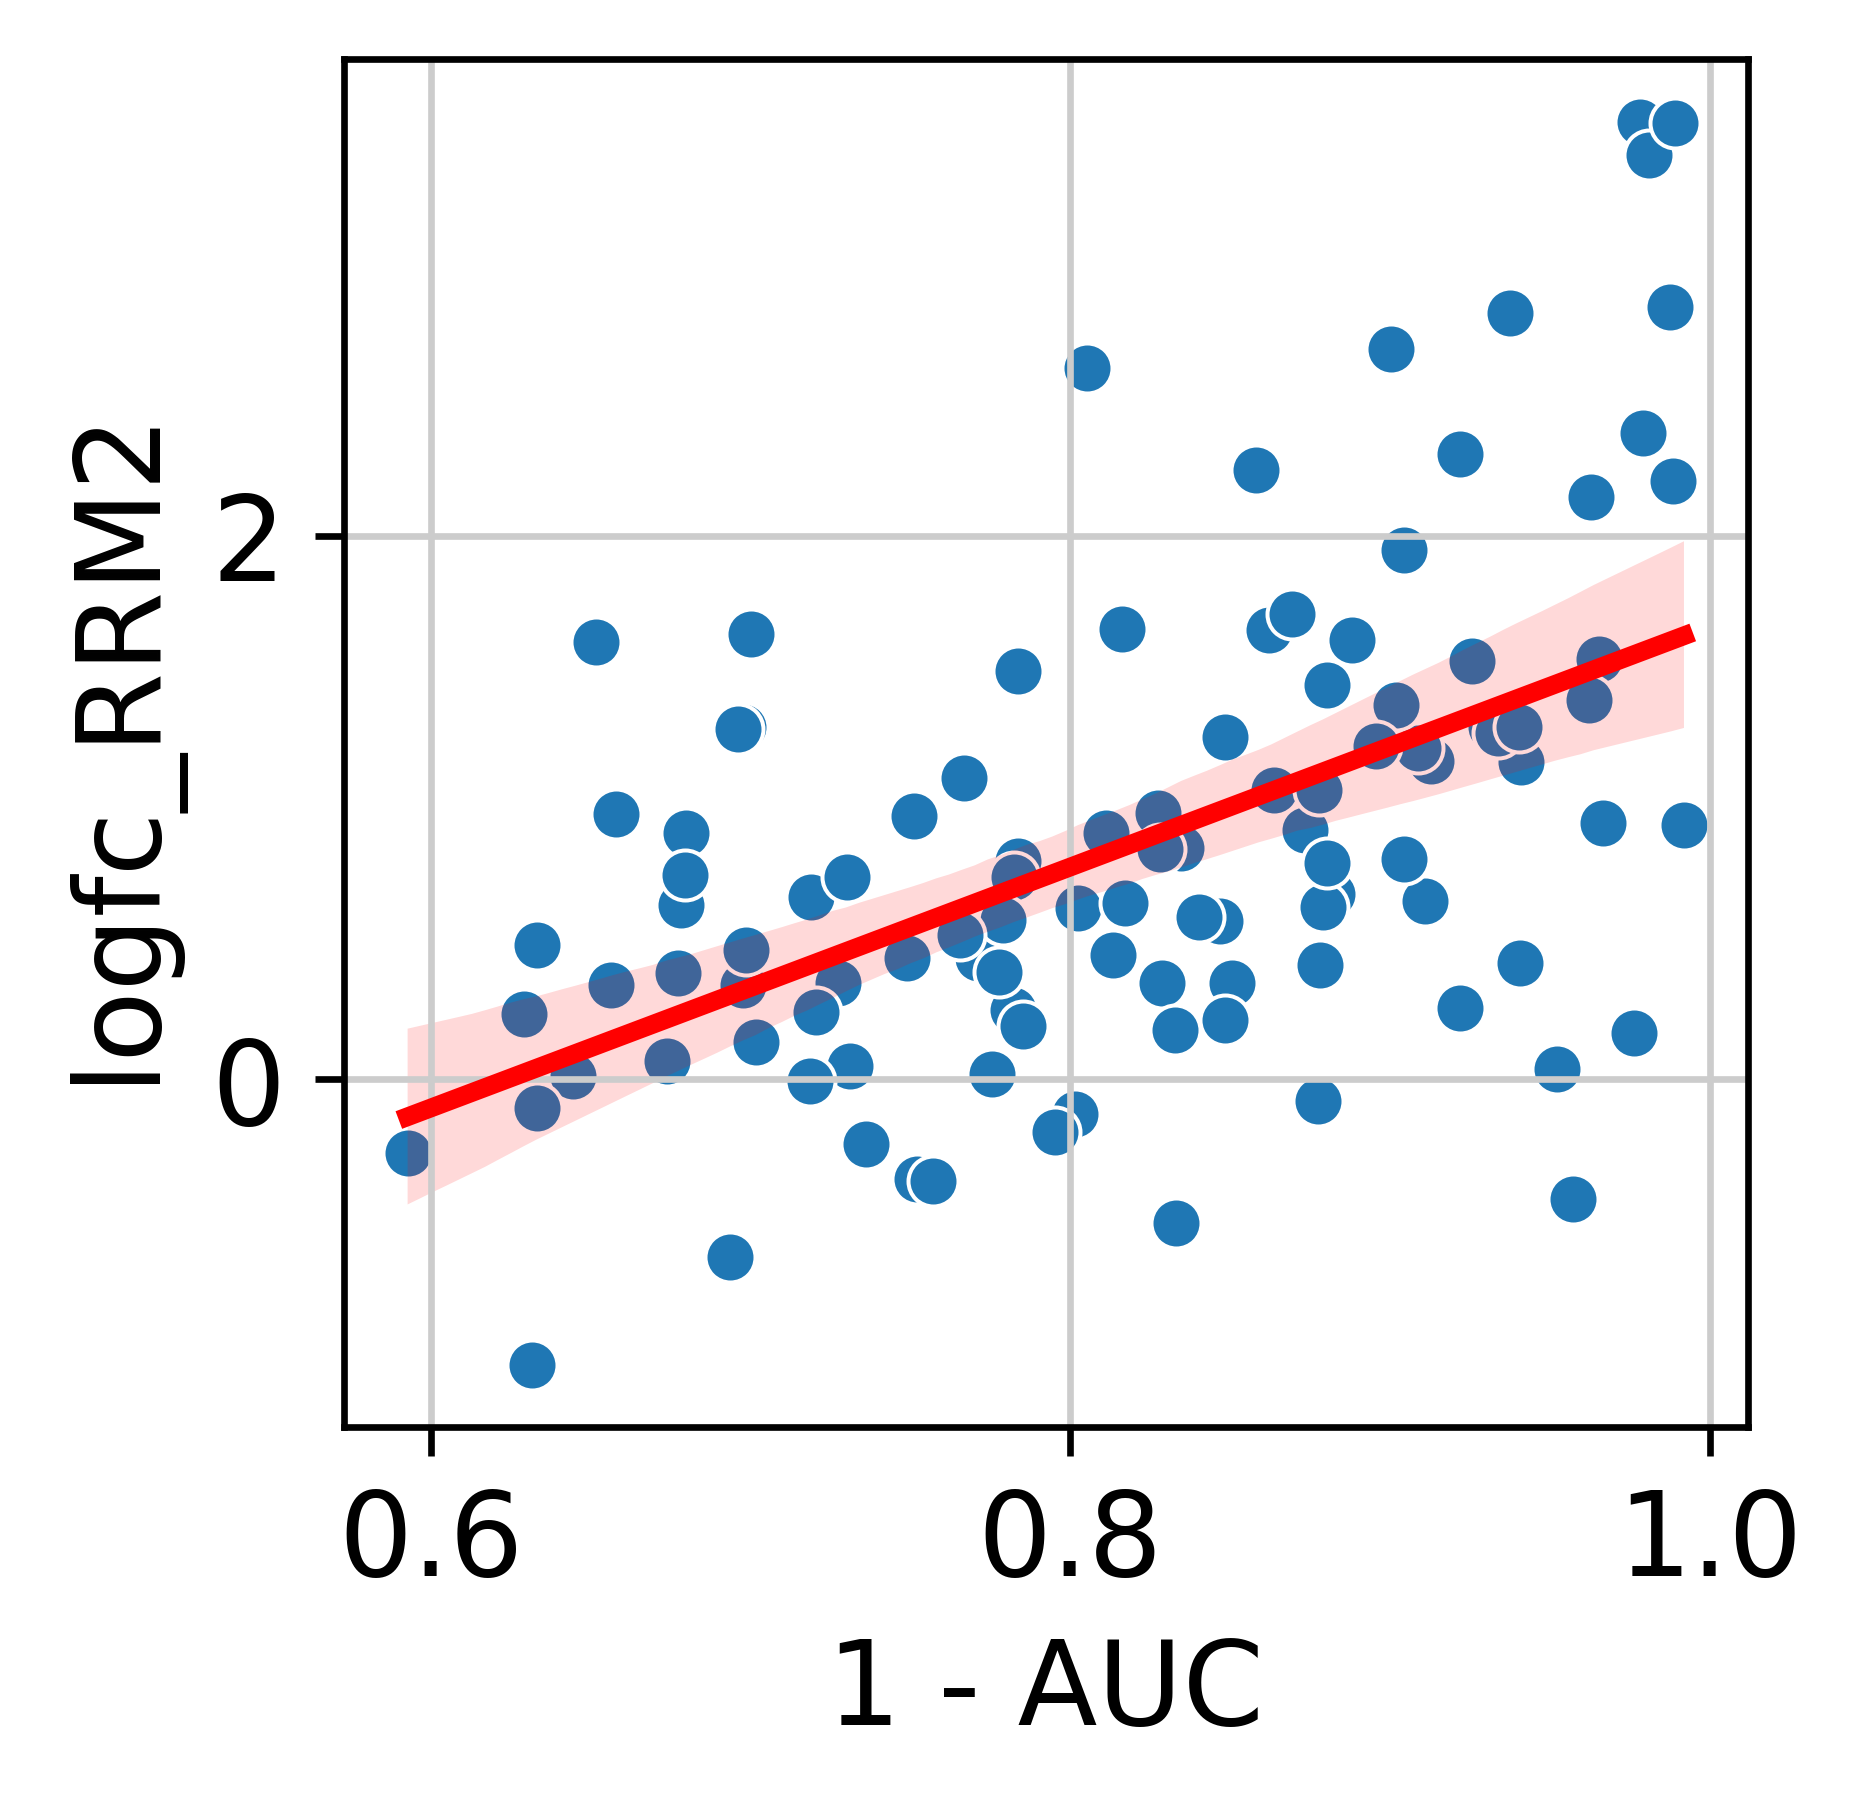

In [28]:
plot_example_linear_regression(adata, "Trametinib", "RRM2", "1 - AUC", logfc_df_trametinib)